# Most preferable place to live in Mumbai - Recommendation

In [ ]:
# Downloading neccessary libraries

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab

In [1]:
# importing libraries

import re
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from bs4 import BeautifulSoup
 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import urllib.parse
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

import folium # map rendering library

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [2]:
# Reading file from local downloaded from the below link:-
# https://data.gov.in/resources/all-india-pincode-directory-contact-details-along-latitude-and-longitude

df_zip = pd.read_csv("all_india_PO_list_without_APS_offices_ver2_lat_long.csv")

In [3]:
df_zip.head()

,officename,pincode,officeType,Deliverystatus,divisionname,regionname,circlename,Taluk,Districtname,statename,Telephone,Related Suboffice,Related Headoffice,longitude,latitude
0,Achalapur B.O,504273,B.O,Delivery,Adilabad,Hyderabad,Andhra Pradesh,Asifabad,Adilabad,TELANGANA,NaN,Rechini S.O,Mancherial H.O,NaN,NaN
1,Ada B.O,504293,B.O,Delivery,Adilabad,Hyderabad,Andhra Pradesh,Asifabad,Adilabad,TELANGANA,NaN,Asifabad S.O,Mancherial H.O,NaN,NaN
2,Adegaon B.O,504307,B.O,Delivery,Adilabad,Hyderabad,Andhra Pradesh,Boath,Adilabad,TELANGANA,NaN,Echoda S.O,Adilabad H.O,NaN,NaN
3,Adilabad Collectorate S.O,504001,S.O,Non-Delivery,Adilabad,Hyderabad,Andhra Pradesh,Adilabad,Adilabad,TELANGANA,08732-226703,NaN,Adilabad H.O,NaN,NaN
4,Adilabad H.O,504001,H.O,Delivery,Adilabad,Hyderabad,Andhra Pradesh,Adilabad,Adilabad,TELANGANA,08732-226738,NaN,NaN,NaN,NaN


In [4]:
#Filtering for Mumbai pincodes
df_mumbai = df_zip[df_zip["Districtname"]=="Mumbai"]

In [5]:
df_mumbai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 81395 to 81634
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   officename          239 non-null    object 
 1   pincode             239 non-null    int64  
 2   officeType          239 non-null    object 
 3   Deliverystatus      239 non-null    object 
 4   divisionname        239 non-null    object 
 5   regionname          239 non-null    object 
 6   circlename          239 non-null    object 
 7   Taluk               181 non-null    object 
 8   Districtname        239 non-null    object 
 9   statename           239 non-null    object 
 10  Telephone           234 non-null    object 
 11  Related Suboffice   4 non-null      object 
 12  Related Headoffice  230 non-null    object 
 13  longitude           0 non-null      float64
 14  latitude            0 non-null      float64
dtypes: float64(2), int64(1), object(12)
memory usage: 2

In [6]:
df_mumbai['officeType'].unique()

array(['S.O', 'H.O', 'B.O'], dtype=object)

In [7]:
#Storing neighborhood names from officename in clean form

df_mumbai["Neighborhood"] = df_mumbai.apply(lambda row: row['officename'].split(' '+row['officeType'])[0], axis=1)
df_mumbai

<ipython-input-7-ee93b28de132>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mumbai["Neighborhood"] = df_mumbai.apply(lambda row: row['officename'].split(' '+row['officeType'])[0], axis=1)


,officename,pincode,officeType,Deliverystatus,divisionname,regionname,circlename,Taluk,Districtname,statename,Telephone,Related Suboffice,Related Headoffice,longitude,latitude,Neighborhood
81395,Antop Hill S.O,400037,S.O,Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-24120290,NaN,Dadar H.O,NaN,NaN,Antop Hill
81396,B P T Colony S.O,400037,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-4100525,NaN,Dadar H.O,NaN,NaN,B P T Colony
81397,B.P.Lane S.O,400003,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,NaN,Mumbai,MAHARASHTRA,022-23421653,NaN,Chinchbunder H.O,NaN,NaN,B.P.Lane
81398,BEST STaff Quarters S.O,400012,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,NaN,Mumbai,MAHARASHTRA,022-24180776,NaN,Chinchbunder H.O,NaN,NaN,BEST STaff Quarters
81399,C G S Colony S.O,400037,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-24097933,NaN,Dadar H.O,NaN,NaN,C G S Colony
81400,Chamarbaug S.O,400012,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-24705407,NaN,Chinchbunder H.O,NaN,NaN,Chamarbaug
81401,Chinchbunder H.O,400009,H.O,Delivery,Mumbai East,Mumbai,Maharashtra,NaN,Mumbai,MAHARASHTRA,022-23771116,NaN,NaN,NaN,NaN,Chinchbunder
81402,Cotton Exchange S.O,400033,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-23742035,NaN,Chinchbunder H.O,NaN,NaN,Cotton Exchange
81403,Dadar Colony S.O,400014,S.O,Non-Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-23774238,NaN,Dadar H.O,NaN,NaN,Dadar Colony
81404,Dadar H.O,400014,H.O,Delivery,Mumbai East,Mumbai,Maharashtra,Mumbai,Mumbai,MAHARASHTRA,022-24168410,NaN,NaN,NaN,NaN,Dadar


In [8]:
#Storing neighborhood details using districtname and pincode for improved searching 

df_mumbai['NeighborhoodDetail'] = df_mumbai['Neighborhood'] + ', ' + df_mumbai['Districtname'] + ', ' + df_mumbai['pincode'].astype(str) #.reset_index().drop("index")


<ipython-input-8-f4a4ac565bbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mumbai['NeighborhoodDetail'] = df_mumbai['Neighborhood'] + ', ' + df_mumbai['Districtname'] + ', ' + df_mumbai['pincode'].astype(str) #.reset_index().drop("index")


In [9]:
relevant_cols = ['officename','regionname','Districtname','longitude','latitude','Neighborhood','NeighborhoodDetail']
df_mumbai[relevant_cols].head()

,officename,regionname,Districtname,longitude,latitude,Neighborhood,NeighborhoodDetail
81395,Antop Hill S.O,Mumbai,Mumbai,NaN,NaN,Antop Hill,"Antop Hill, Mumbai, 400037"
81396,B P T Colony S.O,Mumbai,Mumbai,NaN,NaN,B P T Colony,"B P T Colony, Mumbai, 400037"
81397,B.P.Lane S.O,Mumbai,Mumbai,NaN,NaN,B.P.Lane,"B.P.Lane, Mumbai, 400003"
81398,BEST STaff Quarters S.O,Mumbai,Mumbai,NaN,NaN,BEST STaff Quarters,"BEST STaff Quarters, Mumbai, 400012"
81399,C G S Colony S.O,Mumbai,Mumbai,NaN,NaN,C G S Colony,"C G S Colony, Mumbai, 400037"


#### Using Nominatim to get latitude and longitude details for neighborhood

In [10]:
# Tesing retrieval of latitude and logitude from Nominatum

address = 'Chamarbaug, Mumbai' #df_mumbai.loc[81399,'NeighborhoodDetail'] #checking[81399]
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response)
print(response[0]["lat"])
print(response[0]["lon"])

[{'place_id': 93584296, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 22848660, 'boundingbox': ['19.0017014', '19.0024363', '72.8385341', '72.8409941'], 'lat': '19.0017593', 'lon': '72.8408002', 'display_name': 'Chamarbaug Wala Road, Parel Village, F/S Ward, Zone 2, Mumbai, Mumbai City, Maharashtra, 400012, India', 'class': 'highway', 'type': 'unclassified', 'importance': 0.31}]
19.0017593
72.8408002


In [11]:
# Using Nominatim to get latitude and longitude details for neighborhood

for i in df_mumbai.index:
    
    address = df_mumbai.loc[i,'NeighborhoodDetail']
    print(address)
    
    try:
            url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
            response = requests.get(url).json()
            #print(response)
            latitude = response[0]["lat"]
            longitude = response[0]["lon"]
    except:
            print("Couldn't find this locality")
            latitude = None
            longitude = None
            
    df_mumbai.loc[i,'latitude'] = latitude
    df_mumbai.loc[i,'longitude'] = longitude

# df_mumbai['latitude'] = df_mumbai['NeighborhoodDetail'].apply(lambda x: getLatitude(x))
# df_mumbai['longitude'] = df_mumbai['NeighborhoodDetail'].apply(lambda x: getLongitude(x))

Antop Hill, Mumbai, 400037


/Users/rahularanha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


B P T Colony, Mumbai, 400037
B.P.Lane, Mumbai, 400003
Couldn't find this locality
BEST STaff Quarters, Mumbai, 400012
Couldn't find this locality
C G S Colony, Mumbai, 400037
Couldn't find this locality
Chamarbaug, Mumbai, 400012
Chinchbunder, Mumbai, 400009
Cotton Exchange, Mumbai, 400033
Dadar Colony, Mumbai, 400014
Dadar, Mumbai, 400014
Dockyard Road, Mumbai, 400010
Haffkin Institute, Mumbai, 400012
Couldn't find this locality
Kalachowki, Mumbai, 400033
Couldn't find this locality
Kidwai Nagar, Mumbai, 400031
L B S N E collage, Mumbai, 400033
Couldn't find this locality
Lal Baug, Mumbai, 400012
Mandvi, Mumbai, 400003
Masjid, Mumbai, 400003
Mazgaon Dock, Mumbai, 400010
Mazgaon Road, Mumbai, 400010
Couldn't find this locality
Mazgaon, Mumbai, 400010
Naigaon, Mumbai, 400014
Noor Baug, Mumbai, 400009
Null Bazar, Mumbai, 400003
Couldn't find this locality
Parel Naka, Mumbai, 400012
Parel Rly Work Shop, Mumbai, 400012
Couldn't find this locality
Parel, Mumbai, 400012
Princess Dock, Mumbai

S V Marg, Mumbai, 400007
Couldn't find this locality
S V S Marg, Mumbai, 400028
Couldn't find this locality
Shivaji Park, Mumbai, 400028
Tardeo, Mumbai, 400007
Tulsiwadi, Mumbai, 400034
Worli Colony, Mumbai, 400030
Worli Naka, Mumbai, 400018
Worli Police Camp, Mumbai, 400030
Worli, Mumbai, 400018
Worli Sea Face, Mumbai, 400030
Mumbai G.P.O. , Mumbai, 400001
Couldn't find this locality


In [12]:
df_mumbai[~df_mumbai['longitude'].isna()].count()

officename            169
pincode               169
officeType            169
Deliverystatus        169
divisionname          169
regionname            169
circlename            169
Taluk                 128
Districtname          169
statename             169
Telephone             166
Related Suboffice       2
Related Headoffice    161
longitude             169
latitude              169
Neighborhood          169
NeighborhoodDetail    169
dtype: int64

In [13]:
df_locality = df_mumbai[~df_mumbai['longitude'].isna()][['Neighborhood','pincode','latitude','longitude']].drop_duplicates(keep='first')
df_locality.rename(columns = {'Neighborhood': 'locality'}, inplace=True)
df_locality

,locality,pincode,latitude,longitude
81395,Antop Hill,400037,19.0207608,72.8652556
81396,B P T Colony,400037,19.1717817,72.944423
81400,Chamarbaug,400012,19.0017593,72.8408002
81401,Chinchbunder,400009,18.9567506,72.83705316338038
81402,Cotton Exchange,400033,18.9872492,72.84576154222485
81403,Dadar Colony,400014,19.020798300000003,72.85072890345214
81404,Dadar,400014,19.019282,72.8428757
81405,Dockyard Road,400010,18.9674767,72.8445477
81408,Kidwai Nagar,400031,19.0084356,72.8529813
81410,Lal Baug,400012,18.9935288,72.8424069


In [14]:
df_locality['latitude'] = df_locality['latitude'].astype(float)
df_locality['longitude'] = df_locality['longitude'].astype(float)

In [15]:
df_locality.sort_values(by='locality',inplace=True)

In [16]:
df_locality.head()

,locality,pincode,latitude,longitude
81589,Agripada,400011,18.975302,72.824898
81432,Airport,400099,19.105137,72.855803
81560,Ambewadi,400004,18.990666,72.841256
81434,Andheri,400053,19.119698,72.846420
81433,Andheri East,400069,19.115883,72.854202


In [17]:
df_locality.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 81589 to 81633
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   locality   169 non-null    object 
 1   pincode    169 non-null    int64  
 2   latitude   169 non-null    float64
 3   longitude  169 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 6.6+ KB


### Housing prices data from 99acres

In [18]:
url='https://www.99acres.com/property-rates-and-price-trends-in-mumbai'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

df_housing = pd.read_html(r.text)[0]
print(df_housing.shape)
df_housing.tail()

(1109, 7)


Locality Name                     Buy Rates                        \
     Unnamed: 0_level_1 Price Range (Rs. per sq. ft.)    Q/Q         Trends   
1104     Tolaram Colony   Rs. 15,088 - 17,042/sq. ft.      -  Not Available   
1105         Union Park   Rs. 18,445 - 23,800/sq. ft.      -  Not Available   
1106             Wadala   Rs. 19,082 - 22,525/sq. ft.  6.14%     See Trends   
1107        Wadala East   Rs. 18,105 - 20,230/sq. ft.  1.35%     See Trends   
1108        Wadala West   Rs. 22,440 - 22,440/sq. ft.  8.87%     See Trends   

             Rental Rates                                            
                1 Bedroom            2 Bedroom            3 Bedroom  
1104  Rs. 28,050 - 29,580                    -                    -  
1105                    -  Rs. 40,692 - 46,505                    -  
1106  Rs. 29,814 - 34,212  Rs. 48,620 - 53,295  Rs. 65,558 - 72,532  
1107  Rs. 26,274 - 30,095  Rs. 41,919 - 46,851  Rs. 69,360 - 76,585  
1108  Rs. 23,922 - 27,165  Rs. 45,142 - 47,797                    -

In [19]:
df_housing.columns = ['locality', 'buy_rate', 'percent_change', 'trend', '1bhk_rent_rate', '2bhk_rent_rate', '3bhk_rent_rate']
df_housing.head()


,locality,buy_rate,percent_change,trend,1bhk_rent_rate,2bhk_rent_rate,3bhk_rent_rate
0,Mumbai Thane,Mumbai Thane,Mumbai Thane,Mumbai Thane,Mumbai Thane,Mumbai Thane,Mumbai Thane
1,Aai Nagar,"Rs. 6,035 - 7,905/sq. ft.",-,Not Available,"Rs. 8,500 - 8,500",-,-
2,Anand Nagar,"Rs. 8,160 - 9,308/sq. ft.",-0.48%,See Trends,"Rs. 11,098 - 12,485","Rs. 15,875 - 17,945",-
3,Anu Nagar,-,-,Not Available,-,"Rs. 3,759 - 3,759",-
4,Ashok Nagar,"Rs. 8,372 - 9,775/sq. ft.",-,Not Available,"Rs. 15,693 - 18,462",-,-


#### Manually cleaning data to include more locations with property prices in the already small dataset

In [20]:
df_locality.loc[df_locality['locality']=='Powai Iit','locality'] = 'Hiranandani Gardens - Powai'
#df_locality[df_locality['locality']=='Hiranandani Gardens - Powai']
df_locality.loc[df_locality['locality']=='Hiranandani Gardens - Powai','latitude'] = 19.117628 
df_locality.loc[df_locality['locality']=='Hiranandani Gardens - Powai','longitude'] = 72.9092942
df_locality[df_locality['locality']=='Hiranandani Gardens - Powai']


,locality,pincode,latitude,longitude
81505,Hiranandani Gardens - Powai,400076,19.117628,72.909294


In [21]:

df_locality.loc[df_locality['locality']=='Khar Colony','locality'] = 'Khar'
#df_locality[df_locality['locality']=='Hiranandani Gardens - Powai']
df_locality.loc[df_locality['locality']=='Khar','latitude'] = 19.07177
df_locality.loc[df_locality['locality']=='Khar','longitude'] = 72.835036
df_locality[df_locality['locality']=='Khar']


,locality,pincode,latitude,longitude
81450,Khar,400052,19.07177,72.835036


In [22]:
df_housing.loc[df_housing['locality']=='Cumbala Hill','locality'] = 'Cumballa Hill'

In [23]:
df_housing.loc[df_housing['locality']=='Vikhroli (West)','locality'] = 'Vikhroli'

In [24]:
df_housing.loc[df_housing['locality']=='Sindhi Society Chembur','locality'] = 'Sindhi Society'

In [25]:
df_locality.loc[df_locality['locality']=='IRLA','locality'] = 'Irla'

In [26]:
df_locality.loc[df_locality['locality']=='Kurla','locality'] = 'Kurla west'

In [27]:
df_locality.loc[df_locality['locality']=='Mahim East','locality'] = 'Mahim West'

In [28]:
df_locality.loc[df_locality['locality']=='Dharavi Road','locality'] = 'Sion West'

In [29]:
df_locality.loc[df_locality['locality']=='Sion','locality'] = 'Sion East'

In [30]:
df_locality.loc[df_locality['locality']=='Marol Naka','locality'] = 'Marol'

In [31]:
df_locality.loc[df_locality['locality']=='Malad','locality'] = 'Malad West'
# df_locality.loc[df_locality['locality']=='Malad West','latitude'] = 'Malad West'
df_locality.loc[df_locality['locality']=='Malad West','longitude'] = 72.838966
df_locality.loc[df_locality['locality']=='Malad West']


,locality,pincode,latitude,longitude
81548,Malad West,400064,19.186719,72.838966


In [32]:
# df_locality.loc[df_locality['locality']=='Santacruz(West)','locality'] = 'Malad West'
df_locality.loc[df_locality['locality']=='Santacruz(West)','latitude'] = 19.081363
df_locality.loc[df_locality['locality']=='Santacruz(West)','longitude'] = 72.835036
df_locality.loc[df_locality['locality']=='Santacruz(West)']


,locality,pincode,latitude,longitude
81462,Santacruz(West),400054,19.081363,72.835036


In [33]:
df_housing.sort_values(by='locality')

,locality,buy_rate,percent_change,trend,1bhk_rent_rate,2bhk_rent_rate,3bhk_rent_rate
317,4 Bunglows,"Rs. 20,442 - 25,415/sq. ft.",-3.62%,See Trends,"Rs. 23,375 - 28,518","Rs. 49,088 - 61,582",-
1,Aai Nagar,"Rs. 6,035 - 7,905/sq. ft.",-,Not Available,"Rs. 8,500 - 8,500",-,-
318,Aarey Milk Colony,"Rs. 7,692 - 8,628/sq. ft.",1.04%,See Trends,"Rs. 13,688 - 16,592","Rs. 18,360 - 21,760","Rs. 20,514 - 28,906"
999,Abhyudaya Nagar,"Rs. 24,565 - 30,090/sq. ft.",4.82%,See Trends,"Rs. 13,005 - 16,906",-,"Rs. 96,237 - 1,17,045"
681,Adaigaon,"Rs. 4,335 - 4,802/sq. ft.",-1.83%,See Trends,-,-,-
1000,Adarsh Nagar,"Rs. 37,910 - 40,800/sq. ft.",-,Not Available,"Rs. 15,194 - 19,338",-,-
99,Adharwadi,"Rs. 5,142 - 5,822/sq. ft.",-1.54%,See Trends,"Rs. 6,474 - 8,323","Rs. 9,180 - 10,710",-
234,Agashi,"Rs. 3,570 - 4,250/sq. ft.",-8.16%,See Trends,-,-,-
319,Aghadi Nagar,"Rs. 13,982 - 15,342/sq. ft.",-,Not Available,-,-,-
1001,Agripada,"Rs. 24,522 - 30,940/sq. ft.",-11.29%,See Trends,"Rs. 25,636 - 29,614","Rs. 48,667 - 64,594",-


In [34]:
# Cleaning the data for merging with locality data

df_housing['locality_clean'] = df_housing['locality'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
df_locality['locality_clean'] = df_locality['locality'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
#df_locality_t
df_locality_housing = df_locality.merge(df_housing, how='left', left_on='locality_clean', right_on='locality_clean')
df_locality_housing['buy_rate'] = df_locality_housing['buy_rate'].apply(lambda x: float("nan") if x=='-' else x)

In [35]:
df_locality_housing

,locality_x,pincode,latitude,longitude,locality_clean,locality_y,buy_rate,percent_change,trend,1bhk_rent_rate,2bhk_rent_rate,3bhk_rent_rate
0,Agripada,400011,18.975302,72.824898,Agripada,Agripada,"Rs. 24,522 - 30,940/sq. ft.",-11.29%,See Trends,"Rs. 25,636 - 29,614","Rs. 48,667 - 64,594",-
1,Airport,400099,19.105137,72.855803,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ambewadi,400004,18.990666,72.841256,Ambewadi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Andheri,400053,19.119698,72.846420,Andheri,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andheri East,400069,19.115883,72.854202,AndheriEast,Andheri (East),"Rs. 15,258 - 17,808/sq. ft.",-1.28%,See Trends,"Rs. 21,896 - 25,704","Rs. 33,415 - 38,984","Rs. 43,982 - 53,407"
5,Andheri Railway Station,400058,19.119698,72.846420,AndheriRailwayStation,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Antop Hill,400037,19.020761,72.865256,AntopHill,Antop Hill,"Rs. 17,595 - 20,698/sq. ft.",-,Not Available,-,-,-
7,Anushakti Nagar,400094,19.039578,72.922156,AnushaktiNagar,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Asvini,400005,18.900689,72.816134,Asvini,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Azad Nagar,400053,19.128315,72.840038,AzadNagar,Azad Nagar,"Rs. 17,425 - 19,975/sq. ft.",-1.12%,See Trends,"Rs. 26,350 - 31,025","Rs. 35,945 - 41,936","Rs. 49,938 - 54,188"


In [36]:
# Cleaning the data for getting mean property rate

df_locality_housing['lower_buy_rate'] = df_locality_housing['buy_rate'].apply(lambda x: float(str(x).split(' - ')[0].split('Rs. ')[-1].replace(',', '')))
df_locality_housing['upper_buy_rate'] = df_locality_housing['buy_rate'].apply(lambda x: float(str(x).split(' - ')[-1].split('/sq. ft.')[0].replace(',', '')))

df_locality_housing['mean_property_rate'] = (df_locality_housing['lower_buy_rate'] + df_locality_housing['upper_buy_rate'])/2
df_locality_housing


,locality_x,pincode,latitude,longitude,locality_clean,locality_y,buy_rate,percent_change,trend,1bhk_rent_rate,2bhk_rent_rate,3bhk_rent_rate,lower_buy_rate,upper_buy_rate,mean_property_rate
0,Agripada,400011,18.975302,72.824898,Agripada,Agripada,"Rs. 24,522 - 30,940/sq. ft.",-11.29%,See Trends,"Rs. 25,636 - 29,614","Rs. 48,667 - 64,594",-,24522.0,30940.0,27731.0
1,Airport,400099,19.105137,72.855803,Airport,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ambewadi,400004,18.990666,72.841256,Ambewadi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Andheri,400053,19.119698,72.846420,Andheri,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Andheri East,400069,19.115883,72.854202,AndheriEast,Andheri (East),"Rs. 15,258 - 17,808/sq. ft.",-1.28%,See Trends,"Rs. 21,896 - 25,704","Rs. 33,415 - 38,984","Rs. 43,982 - 53,407",15258.0,17808.0,16533.0
5,Andheri Railway Station,400058,19.119698,72.846420,AndheriRailwayStation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Antop Hill,400037,19.020761,72.865256,AntopHill,Antop Hill,"Rs. 17,595 - 20,698/sq. ft.",-,Not Available,-,-,-,17595.0,20698.0,19146.5
7,Anushakti Nagar,400094,19.039578,72.922156,AnushaktiNagar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Asvini,400005,18.900689,72.816134,Asvini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Azad Nagar,400053,19.128315,72.840038,AzadNagar,Azad Nagar,"Rs. 17,425 - 19,975/sq. ft.",-1.12%,See Trends,"Rs. 26,350 - 31,025","Rs. 35,945 - 41,936","Rs. 49,938 - 54,188",17425.0,19975.0,18700.0


In [37]:
# Assigning price values to prime residential locations based on their actual prices

df_locality_housing.loc[df_locality_housing['locality_x']=='Worli Sea Face','mean_property_rate'] = 50000
df_locality_housing.loc[df_locality_housing['locality_x']=='Hiranandani Gardens - Powai','mean_property_rate'] = 35000

In [38]:
df_locality_housing[~df_locality_housing['mean_property_rate'].isna()][['locality_x','pincode','latitude','longitude','buy_rate','lower_buy_rate','upper_buy_rate','mean_property_rate']].head()


,locality_x,pincode,latitude,longitude,buy_rate,lower_buy_rate,upper_buy_rate,mean_property_rate
0,Agripada,400011,18.975302,72.824898,"Rs. 24,522 - 30,940/sq. ft.",24522.0,30940.0,27731.0
4,Andheri East,400069,19.115883,72.854202,"Rs. 15,258 - 17,808/sq. ft.",15258.0,17808.0,16533.0
6,Antop Hill,400037,19.020761,72.865256,"Rs. 17,595 - 20,698/sq. ft.",17595.0,20698.0,19146.5
9,Azad Nagar,400053,19.128315,72.840038,"Rs. 17,425 - 19,975/sq. ft.",17425.0,19975.0,18700.0
12,Bandra West,400050,19.058336,72.830267,"Rs. 33,065 - 39,015/sq. ft.",33065.0,39015.0,36040.0


#### Preparing final housing data frame and analysing neighborhoods based on their property value

In [39]:
df_housing_map = df_locality_housing[['locality_x','pincode','latitude','longitude','mean_property_rate']]
df_housing_map = df_housing_map[~df_housing_map['mean_property_rate'].isna()]
df_housing_map.rename(columns = {'locality_x':'locality'},inplace=True)

In [40]:
df_housing_map.count()

locality              95
pincode               95
latitude              95
longitude             95
mean_property_rate    95
dtype: int64

In [41]:
df_housing_map['locality'].value_counts().head()

Tilak Nagar      4
Shivaji Nagar    3
Girgaon          1
Pant Nagar       1
Tardeo           1
Name: locality, dtype: int64

In [42]:
df_housing_map = df_housing_map.groupby(['locality','pincode','latitude','longitude']).max().reset_index()#['locality'].value_counts()
df_housing_map.count()

locality              90
pincode               90
latitude              90
longitude             90
mean_property_rate    90
dtype: int64

In [43]:
df_housing_map.head()

,locality,pincode,latitude,longitude,mean_property_rate
0,Agripada,400011,18.975302,72.824898,27731.0
1,Andheri East,400069,19.115883,72.854202,16533.0
2,Antop Hill,400037,19.020761,72.865256,19146.5
3,Azad Nagar,400053,19.128315,72.840038,18700.0
4,Bandra West,400050,19.058336,72.830267,36040.0


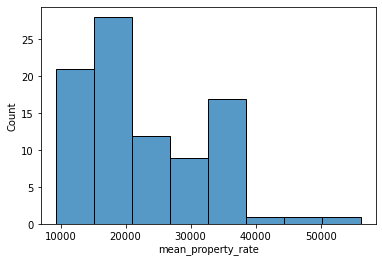

In [44]:
sns.histplot(df_housing_map['mean_property_rate'])

/Users/rahularanha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


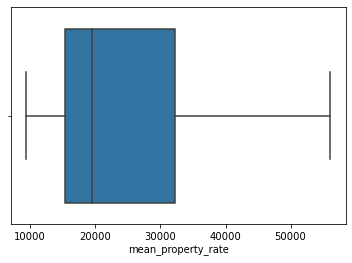

In [45]:
sns.boxplot(df_housing_map['mean_property_rate'])

<b>Inference from above two graphs</b>
1. Housing prices in Mumbai are right skewed with median value in the lower range. This means that property rates of most neighborhoods lie in the lower price range but there are few neighborhoods that are really expensive.
2. Median (most typical price) per sq. ft. price in Mumbai is ~ Rs. 19500 to 20000. 
3. There is a substantial increase in neighborhoods that are priced in the expensive range (more than Rs 30000).

In [46]:
df_housing_map['mean_property_rate'].quantile(.7)

28151.899999999994

In [47]:
df_housing_map[(df_housing_map['mean_property_rate']>=df_housing_map['mean_property_rate'].quantile(.7))&(df_housing_map['mean_property_rate']<=df_housing_map['mean_property_rate'].quantile(.9))]


,locality,pincode,latitude,longitude,mean_property_rate
4,Bandra West,400050,19.058336,72.830267,36040.0
5,Bandra(East),400051,19.061657,72.849811,29686.5
14,Charni Road,400004,18.952456,72.817440,33468.5
19,Colaba,400005,18.915091,72.825969,32321.0
21,Dadar,400014,19.019282,72.842876,31875.0
25,Girgaon,400004,18.952148,72.822058,35147.5
29,Grant Road,400007,18.962964,72.817856,29134.0
31,Hiranandani Gardens - Powai,400076,19.117628,72.909294,35000.0
34,Jacob Circle,400011,18.981053,72.826786,33235.0
37,Juhu,400049,19.107021,72.827528,35636.5


In [48]:
start = df_housing_map['mean_property_rate'].quantile(0)
low = df_housing_map['mean_property_rate'].quantile(.4)
med = df_housing_map['mean_property_rate'].quantile(.7)
high = df_housing_map['mean_property_rate'].quantile(.9)
end = df_housing_map['mean_property_rate'].quantile(1)

In [49]:
bin_vals = [start,low,med,high,end]
label_vals = ['yellow','green','blue','red']

In [50]:
df_housing_map['marker_color'] = pd.cut(df_housing_map['mean_property_rate'], bins=bin_vals, labels=label_vals)


In [51]:
df_housing_map['marker_color'].value_counts()

yellow    35
green     27
blue      18
red        9
Name: marker_color, dtype: int64

In [52]:
# address = 'Mumbai, IN'

# geolocator = Nominatim(user_agent="to_explorer")
# location = geolocator.geocode(address)
# latitude = location.latitude
# longitude = location.longitude
# print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

address = "Mumbai, India"
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
# print(response)
mumbai_latitude = float(response[0]["lat"])
mumbai_longitude = float(response[0]["lon"])

print("latitude", mumbai_latitude)
print("longitude", mumbai_latitude)

latitude 19.0759899
longitude 19.0759899


In [53]:
# create map of Mumbai using latitude and longitude values
map_mumbai = folium.Map(location=[mumbai_latitude, mumbai_longitude], zoom_start=10)

# add markers to map
for lat, lng, locality, col in zip(df_housing_map['latitude'], df_housing_map['longitude'], df_housing_map['locality'], df_housing_map['marker_color']):
    label = '{}'.format(locality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=col,
        fill=True,
        fill_color='#999999',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

<b>Legend :- Property Prices</b>
<li>Yellow - Low prices
<li>Green - Avg prices
<li>Blue - High prices
<li>Red - Very high prices

<b>Inference</b>
1. From the above map, it is clearly visible that Neighborhoods closer to the west and southern coast of Mumbai are most expensive. 
2. Price reduces as we move more inland and North of Mumbai. 
3. In the central Mumbai suburbs, there is a particularly expensive location of Hiranandani Gardens, Powai to live. Further analysis of neighborhood facilities will help understand why.


### Preparing Final Data Frame for further Analysis

In [54]:
df_locality_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 173
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   locality_x          174 non-null    object 
 1   pincode             174 non-null    int64  
 2   latitude            174 non-null    float64
 3   longitude           174 non-null    float64
 4   locality_clean      174 non-null    object 
 5   locality_y          94 non-null     object 
 6   buy_rate            94 non-null     object 
 7   percent_change      94 non-null     object 
 8   trend               94 non-null     object 
 9   1bhk_rent_rate      94 non-null     object 
 10  2bhk_rent_rate      94 non-null     object 
 11  3bhk_rent_rate      94 non-null     object 
 12  lower_buy_rate      94 non-null     float64
 13  upper_buy_rate      94 non-null     float64
 14  mean_property_rate  95 non-null     float64
dtypes: float64(5), int64(1), object(9)
memory usage: 21.8+ KB

In [55]:
df_locality_housing[~df_locality_housing['mean_property_rate'].isna()]

,locality_x,pincode,latitude,longitude,locality_clean,locality_y,buy_rate,percent_change,trend,1bhk_rent_rate,2bhk_rent_rate,3bhk_rent_rate,lower_buy_rate,upper_buy_rate,mean_property_rate
0,Agripada,400011,18.975302,72.824898,Agripada,Agripada,"Rs. 24,522 - 30,940/sq. ft.",-11.29%,See Trends,"Rs. 25,636 - 29,614","Rs. 48,667 - 64,594",-,24522.0,30940.0,27731.0
4,Andheri East,400069,19.115883,72.854202,AndheriEast,Andheri (East),"Rs. 15,258 - 17,808/sq. ft.",-1.28%,See Trends,"Rs. 21,896 - 25,704","Rs. 33,415 - 38,984","Rs. 43,982 - 53,407",15258.0,17808.0,16533.0
6,Antop Hill,400037,19.020761,72.865256,AntopHill,Antop Hill,"Rs. 17,595 - 20,698/sq. ft.",-,Not Available,-,-,-,17595.0,20698.0,19146.5
9,Azad Nagar,400053,19.128315,72.840038,AzadNagar,Azad Nagar,"Rs. 17,425 - 19,975/sq. ft.",-1.12%,See Trends,"Rs. 26,350 - 31,025","Rs. 35,945 - 41,936","Rs. 49,938 - 54,188",17425.0,19975.0,18700.0
12,Bandra West,400050,19.058336,72.830267,BandraWest,Bandra (West),"Rs. 33,065 - 39,015/sq. ft.",1.08%,See Trends,"Rs. 42,330 - 51,000","Rs. 65,450 - 80,750","Rs. 1,11,520 - 1,42,800",33065.0,39015.0,36040.0
13,Bandra(East),400051,19.061657,72.849811,BandraEast,Bandra (East),"Rs. 26,308 - 33,065/sq. ft.",5.45%,See Trends,"Rs. 21,991 - 31,416","Rs. 58,378 - 66,104","Rs. 87,577 - 1,21,635",26308.0,33065.0,29686.5
14,Bangur Nagar,400104,19.168814,72.833678,BangurNagar,Bangur Nagar,"Rs. 16,022 - 18,700/sq. ft.",4.45%,See Trends,"Rs. 19,516 - 23,324","Rs. 24,710 - 34,463",-,16022.0,18700.0,17361.0
15,Barve Nagar,400084,19.095283,72.900178,BarveNagar,Barve Nagar,"Rs. 13,940 - 15,300/sq. ft.",-,Not Available,-,-,-,13940.0,15300.0,14620.0
17,Bhandup East,400042,19.148557,72.947066,BhandupEast,Bhandup (East),"Rs. 12,792 - 15,215/sq. ft.",-8.52%,See Trends,"Rs. 18,431 - 22,212","Rs. 34,238 - 38,518","Rs. 46,028 - 54,506",12792.0,15215.0,14003.5
19,Bhandup West,400078,19.146264,72.933946,BhandupWest,Bhandup (West),"Rs. 12,495 - 14,705/sq. ft.",-6.76%,See Trends,"Rs. 18,153 - 21,019","Rs. 26,806 - 30,529","Rs. 37,182 - 42,992",12495.0,14705.0,13600.0


Out of a total of 169 neighborhoods, we have property values for 90 of the locations. We could handle the missing values by filling them up with an appropriate statistic like median to assign the most typical value. But property rates in Mumbai are extrememly disparate in nature and hence some really expensive or really cheap places might get assigned an incorrect value. Moreover, most of the main locations are covered in the 90 locations for which we have data. Hence we can drop the other locations from further analysis and use locations present in df_housing_map as the final list

In [56]:
#df_locality_housing['mean_property_rate'].fillna(df_locality_housing['mean_property_rate'].quantile(0.5), inplace=True)


In [57]:
df_locality_copy = df_locality.copy()
df_locality = df_housing_map[['locality','pincode','latitude','longitude','mean_property_rate']].reset_index(drop=True)
#df_locality.rename(columns = {'locality_x':'locality'},inplace=True)
df_locality

,locality,pincode,latitude,longitude,mean_property_rate
0,Agripada,400011,18.975302,72.824898,27731.0
1,Andheri East,400069,19.115883,72.854202,16533.0
2,Antop Hill,400037,19.020761,72.865256,19146.5
3,Azad Nagar,400053,19.128315,72.840038,18700.0
4,Bandra West,400050,19.058336,72.830267,36040.0
5,Bandra(East),400051,19.061657,72.849811,29686.5
6,Bangur Nagar,400104,19.168814,72.833678,17361.0
7,Barve Nagar,400084,19.095283,72.900178,14620.0
8,Bhandup East,400042,19.148557,72.947066,14003.5
9,Bhandup West,400078,19.146264,72.933946,13600.0


In [58]:
df_locality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   locality            90 non-null     object 
 1   pincode             90 non-null     int64  
 2   latitude            90 non-null     float64
 3   longitude           90 non-null     float64
 4   mean_property_rate  90 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.6+ KB


### Using the Foursquare API to get venue info for every locality

In [262]:
# Define Foursquare API credentials

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [60]:
# defining function to exract info from json returned by the API into data frame

def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Hood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [61]:
# getting nearby venues for Mumbai's neighborhoods, define radius and number of venues to extract

rad = 500
lim = 100

mumbai_venues = getNearbyVenues(names=df_locality['locality'],
                                   latitudes=df_locality['latitude'],
                                   longitudes=df_locality['longitude'],
                                 radius=rad,
                                 LIMIT=lim)

In [62]:
mumbai_venues.head()

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agripada,18.975302,72.824898,Celejor,18.975844,72.823679,Bakery
1,Agripada,18.975302,72.824898,cafe coffee day,18.976988,72.824051,Coffee Shop
2,Agripada,18.975302,72.824898,YMCA,18.972187,72.823491,Athletics & Sports
3,Agripada,18.975302,72.824898,YMCA Ground,18.972006,72.824011,Soccer Field
4,Agripada,18.975302,72.824898,Mumbai Central Platform No. 2,18.975996,72.820417,Platform


In [63]:
mumbai_venues['Venue Category'].value_counts()

Indian Restaurant                           153
Café                                         66
Chinese Restaurant                           51
Fast Food Restaurant                         49
Coffee Shop                                  45
Bar                                          40
Ice Cream Shop                               35
Bakery                                       35
Restaurant                                   31
Hotel                                        26
Pizza Place                                  26
Lounge                                       21
Asian Restaurant                             21
Italian Restaurant                           19
Snack Place                                  17
Clothing Store                               17
Gym / Fitness Center                         16
Smoke Shop                                   16
Vegetarian / Vegan Restaurant                16
Dessert Shop                                 15
Sandwich Place                          

In [64]:
mumbai_venues['Venue Category'].nunique()

175

### Mapping venues categories to macro groups

There are several venue categories that can be grouped into one and having a cleaner concise list would help in systematic analyis and building of recommendation.

In [65]:
mumbai_venues.rename(columns={'Venue Category':'Venue SubCategory'}, inplace=True)

In [66]:
mumbai_venues['Venue SubCategory'].unique()

array(['Bakery', 'Coffee Shop', 'Athletics & Sports', 'Soccer Field',
       'Platform', 'Indian Restaurant', 'Pizza Place', 'Hotel',
       'Camera Store', 'Shopping Mall', 'Chinese Restaurant',
       'Electronics Store', 'Bar', 'Food Truck', 'Diner', 'Bus Station',
       'Falafel Restaurant', 'Pub', 'Asian Restaurant', 'Snack Place',
       'Vegetarian / Vegan Restaurant', 'Burger Joint', 'Sandwich Place',
       'Bowling Alley', 'Train Station', 'Metro Station', 'Playground',
       'Ice Cream Shop', 'Pharmacy', 'College Cafeteria', 'Park', 'Café',
       'College Auditorium', 'Deli / Bodega', 'Gourmet Shop',
       'French Restaurant', 'Gym / Fitness Center', 'Salad Place',
       'Italian Restaurant', 'Bookstore', 'Event Space', 'Arcade',
       'Smoke Shop', 'BBQ Joint', 'Spanish Restaurant', 'Clothing Store',
       "Women's Store", 'Indie Movie Theater', 'Dessert Shop',
       'Mediterranean Restaurant', 'Fast Food Restaurant', 'Bagel Shop',
       "Men's Store", 'Beer Garden

In [67]:
# Personas

# indian, foreigner
# young adult - 20s, mid adult - 30s to 40s, oldie 50s+
# family, bachelor
# modern, old-fashioned
# simple living, out-going/flashy
# modest spending, medium spending, rich


macro_mapping_dict = {     
        'Event Space':'sports_fitness_wellness', 'Dance Studio':'sports_fitness_wellness', 'Mountain':'nature_view', 'Bakery':'fastfoods', 
       'Bank':'stores_dailyconveniences', 'Athletics & Sports':'sports_fitness_wellness', 'Soccer Field':'sports_fitness_wellness', 
       'Indian Restaurant':'restaurant', 'Donut Shop':'fastfoods', 'Café':'café_coffee', 'Whisky Bar':'bars_nightlife', 'Bistro':'café_coffee',
       'Food Court':'restaurant', 'Nightclub':'bars_nightlife', 'Bar':'bars_nightlife', 'Restaurant':'restaurant', 'Lounge':'bars_nightlife',
       'Sandwich Place':'fastfoods', 'Pizza Place':'fastfoods', 'Cocktail Bar':'bars_nightlife', 'Cafeteria':'café_coffee', 'Hotel':'hotel',
       'Fast Food Restaurant':'fastfoods', 'Sports Bar':'bars_nightlife', 'Airport':'transport_vicinity', 'Coffee Shop':'café_coffee',
       'Vegetarian / Vegan Restaurant':'restaurant', 'Snack Place':'fastfoods', 'Department Store':'stores_dailyconveniences',
       'Pool':'sports_fitness_wellness', 'Juice Bar':'fastfoods', 'Breakfast Spot':'restaurant', 'Italian Restaurant':'restaurant',
       'Chinese Restaurant':'restaurant', 'Camera Store':'shopping', 'Shopping Mall':'shopping','Platform':'transport_vicinity',
       'Light Rail Station':'transport_vicinity', 'Gym / Fitness Center':'sports_fitness_wellness', 'Electronics Store':'shopping',
       'Hotel Bar':'bars_nightlife', 'Golf Course':'sports_fitness_wellness', 'Burger Joint':'fastfoods', 'Recording Studio':'arts_culture',
       'Luggage Store':'shopping', 'Salon / Barbershop':'stores_dailyconveniences', 'Pharmacy':'stores_dailyconveniences','Diner':'restaurant',
       'Brazilian Restaurant':'restaurant', 'Gym':'sports_fitness_wellness', 'Market':'stores_dailyconveniences', 'Theme Park':'fun_recreation',
       'Gaming Cafe':'fun_recreation', 'Train Station':'transport_vicinity', 'Flower Shop':'shopping', 'South Indian Restaurant':'restaurant',
       'Middle Eastern Restaurant':'restaurant', 'Dessert Shop':'fastfoods', 'Ice Cream Shop':'fastfoods','Moving Target':'transport_vicinity',
       'Miscellaneous Shop':'shopping', 'Hostel':'hotel', 'Volleyball Court':'sports_fitness_wellness', 'Sports Club':'sports_fitness_wellness',
       'Smoke Shop':'bars_nightlife', 'Theater':'fun_recreation', 'Seafood Restaurant':'restaurant', 'Park':'sports_fitness_wellness',
       'Clothing Store':'shopping', 'Irani Cafe':'restaurant', 'Monument / Landmark':'fun_recreation', 'Bookstore':'stores_dailyconveniences',
       'Mughlai Restaurant':'restaurant', 'Multiplex':'fun_recreation', 'Boutique':'fun_recreation', 'History Museum':'fun_recreation',
       'Flea Market':'arts_culture', 'Parsi Restaurant':'restaurant', 'BBQ Joint':'restaurant', 'Tea Room':'café_coffee',
       'Multicuisine Indian Restaurant':'restaurant', 'Design Studio':'arts_culture', 'Bowling Alley':'fun_recreation', 'Bridal Shop':'shopping',
       'Boat or Ferry':'fun_recreation', 'Shop & Service':'shopping', 'Convenience Store':'stores_dailyconveniences', 'Buffet':'restaurant', 
       'Bus Station':'transport_vicinity', 'Molecular Gastronomy Restaurant':'restaurant', 'Movie Theater':'fun_recreation',
       'Pub':'bars_nightlife', 'Arcade':'fun_recreation', 'Playground':'sports_fitness_wellness', 'Bridge':'transport_vicinity', 'Pool Hall':'fun_recreation',
       'American Restaurant':'restaurant', 'Indian Sweet Shop':'fastfoods', 'Jewelry Store':'shopping', 'Beer Garden':'café_coffee',
       'Cricket Ground':'sports_fitness_wellness', 'Scenic Lookout':'nature_view', 'Hockey Arena':'sports_fitness_wellness', 'Roof Deck':'nature_view',
       'General Entertainment':'fun_recreation', 'Mexican Restaurant':'restaurant','Airport Service':'transport_vicinity', 
       'Field':'sports_fitness_wellness', 'Indie Movie Theater':'arts_culture', 'Food Truck':'fastfoods', 'Thai Restaurant':'restaurant',
       'Brewery':'café_coffee', 'Asian Restaurant':'restaurant', 'College Gym':'sports_fitness_wellness', 'Bed & Breakfast':'hotel',
       'Pet Store':'shopping', 'Food & Drink Shop':'stores_dailyconveniences', 'Health & Beauty Service':'stores_dailyconveniences',
       'Garden':'sports_fitness_wellness', 'Yoga Studio':'sports_fitness_wellness', 'Sporting Goods Shop':'shopping', 'Motorcycle Shop':'shopping',
       'Steakhouse':'restaurant', 'Beach':'nature_view', 'Gastropub':'bars_nightlife', 'Opera House':'arts_culture', 
       'Gift Shop':'shopping', 'Spa':'sports_fitness_wellness', 'Train':'transport_vicinity', 'College Academic Building':'irrelevant',
       'Japanese Restaurant':'restaurant', 'Other Great Outdoors':'nature_view', 'Plaza':'shopping', 'Stadium':'sports_fitness_wellness',
       "Men's Store":'shopping', 'Racetrack':'sports_fitness_wellness', "Women's Store":'shopping', 'Salad Place':'café_coffee','Food':'fastfoods',
       'Frozen Yogurt Shop':'café_coffee', 'Farmers Market':'stores_dailyconveniences','Falafel Restaurant':'restaurant', 
       'Basketball Court':'sports_fitness_wellness', 'Cupcake Shop':'fastfoods', 'Fried Chicken Joint':'fastfoods','Metro Station':'transport_vicinity',
       'New American Restaurant':'restaurant', 'Mediterranean Restaurant':'restaurant', 'Deli / Bodega':'restaurant',
       'Noodle House':'restaurant', 'Dim Sum Restaurant':'restaurant', 'Furniture / Home Store':'stores_dailyconveniences','Shoe Store':'shopping',
       'Comedy Club':'arts_culture', 'Cosmetics Shop':'shopping', 'Toy / Game Store':'stores_dailyconveniences','Sculpture Garden':'arts_culture', 
       'Gourmet Shop':'shopping', 'Music Venue':'arts_culture', 'Punjabi Restaurant':'restaurant', 'Office':'irrelevant',
       'Hookah Bar':'bars_nightlife', 'Pier':'nature_view', 'ATM':'stores_dailyconveniences', 'Government Building':'irrelevant',
       'Harbor / Marina':'nature_view', 'Grocery Store':'stores_dailyconveniences','Supermarket':'stores_dailyconveniences','Forest':'nature_view',
       'Paper / Office Supplies Store':'stores_dailyconveniences', 'Hot Dog Joint':'fastfoods', 'Concert Hall':'fun_recreation','Convention Center':'fun_recreation',
       'Automotive Shop':'shopping', 'Martial Arts Dojo':'sports_fitness_wellness', 'Art Gallery':'arts_culture','Club House':'sports_fitness_wellness',
       'Airport Lounge':'café_coffee', 'Duty-free Shop':'bars_nightlife', 'Airport Terminal':'transport_vicinity', 'Track':'sports_fitness_wellness',
       'Taxi Stand':'transport_vicinity', 'Airport Food Court':'fastfoods', 'Mobile Phone Shop':'stores_dailyconveniences','Rest Area':'fun_recreation',
       'Music Store':'fun_recreation', 'Cheese Shop':'shopping', 'Arts & Crafts Store':'arts_culture','Halal Restaurant':'restaurant',
       'Neighborhood':'stores_dailyconveniences', 'Modern European Restaurant':'restaurant', 'Sushi Restaurant':'restaurant',
       'Road':'transport_vicinity', 'Fish & Chips Shop':'restaurant', 'Greek Restaurant':'restaurant', 'Speakeasy':'bars_nightlife',
       'Latin American Restaurant':'restaurant', 'Comfort Food Restaurant':'restaurant', 'Zoo':'fun_recreation', 'Aquarium':'fun_recreation', 
       'Massage Studio':'sports_fitness_wellness', 'Liquor Store':'bars_nightlife', 'Record Shop':'fun_recreation', 'Lake':'nature_view',
       'Maharashtrian Restaurant':'restaurant', 'Motel':'hotel', 'Campground':'nature_view','Bike Rental / Bike Share':'sports_fitness_wellness',
       'Goan Restaurant':'restaurant', 'Fish Market':'stores_dailyconveniences', 'German Restaurant':'restaurant',
       'Lighthouse':'nature_view', 'Video Store':'fun_recreation', 'Antique Shop':'shopping', 'Tennis Court':'sports_fitness_wellness',
       'Outdoors & Recreation':'nature_view', 'Wine Bar':'bars_nightlife', 'Performing Arts Venue':'arts_culture', 'Sake Bar':'restaurant',  
       'Chaat Place':'fastfoods', 'French Restaurant':'restaurant', 'Wine Shop':'bars_nightlife', 'Afghan Restaurant':'restaurant',
       'Plane':'transport_vicinity', 'Historic Site':'arts_culture', 'Intersection':'transport_vicinity', 'Dog Run':'transport_vicinity',
       'Martial Arts School':'sports_fitness_wellness', 'Dive Bar':'bars_nightlife', 'Shawarma Place':'fastfoods', 'Dumpling Restaurant':'fastfoods',
       'Szechuan Restaurant':'fastfoods', 'Football Stadium':'sports_fitness_wellness', 'Insurance Office':'irrelevant','Burrito Place':'fastfoods',
       'Burrito Place':'fastfoods','Rental Car Location':'transport_vicinity','Accessories Store':'shopping','Soccer Stadium':'sports_fitness_wellness',
       'Hotel Pool':'sports_fitness_wellness', 'Community Center':'fun_recreation', 'College Auditorium':'fun_recreation',
       'Spanish Restaurant':'restaurant', 'Garden Center':'fun_recreation', 'Tapas Restaurant':'restaurant', 
       'Persian Restaurant':'restaurant', 'Bagel Shop':'fastfoods', 'Resort':'hotel', 'Souvenir Shop':'shopping',
       'Fruit & Vegetable Store':'stores_dailyconveniences', 'Moroccan Restaurant':'restaurant', 'Bus Stop':'transport_vicinity',
       'Kids Store':'stores_dailyconveniences', 'English Restaurant':'restaurant',
       'Bengali Restaurant':'restaurant', 'Recreation Center':'fun_recreation', 'Cantonese Restaurant':'restaurant',
       'Indian Chinese Restaurant':'restaurant', 'Butcher':'stores_dailyconveniences', 
       'Residential Building (Apartment / Condo)':'hotel', 'Food Service':'fastfoods', 'Farm':'nature_view',
       'North Indian Restaurant':'restaurant', 'Museum':'arts_culture', 'Art Museum':'arts_culture', 'Street Art':'arts_culture',
       'Public Art':'arts_culture', 'Health Food Store':'stores_dailyconveniences', 'Hong Kong Restaurant':'restaurant',
       'Pastry Shop':'fastfoods', 'Temple':'stores_dailyconveniences', 'Malay Restaurant':'restaurant', 'Advertising Agency':'irrelevant',
       'Vietnamese Restaurant':'restaurant', 'Stationery Store':'stores_dailyconveniences', 'Trail':'nature_view',
       'College Cafeteria':'fastfoods', 'Gluten-free Restaurant':'restaurant', 'Korean Restaurant':'restaurant',
       'South American Restaurant':'restaurant', 'Business Service':'irrelevant', 'Factory':'irrelevant',
       'Big Box Store':'shopping', 'Creperie':'restaurant', 'Tex-Mex Restaurant':'restaurant', 'Dhaba':'restaurant',
       'Building':'irrelevant', 'River':'nature_view', 'Adult Boutique':'shopping', 'Coworking Space':'café_coffee',
       'Track Stadium':'sports_fitness_wellness', 'Gun Range':'sports_fitness_wellness','High School':'irrelevant',                      
       'IT Services':'stores_dailyconveniences', 'Auto Garage':'stores_dailyconveniences', 'Tunnel':'transport_vicinity', 
        'Beer Bar':'bars_nightlife', 'Amphitheater':'arts_culture', 'Portuguese Restaurant':'restaurant',
         'Baseball Field':'sports_fitness_wellness', 'Waterfront':'nature_view', 'Video Game Store':'shopping',
        'Candy Store':'fastfoods','Rajasthani Restaurant':'fastfoods','College Football Field':'sports_fitness_wellness',
        'Bus Line':'transport_vicinity', 'Gym Pool':'sports_fitness_wellness','Soup Place':'fastfoods'
}

# :'café_coffee'
# :'fastfoods',
# :'bars_nightlife',    
# :'nature_view', 
# :'shopping', 
# :'transport_vicinity', 
# :'stores_dailyconveniences'
# :'sports_fitness_wellness'
# :'arts_culture'
# :'fun_recreation', 
# :'restaurant', 
# :'hotel'

# :'indian_restaurant' 
# :'cuisine_restaurants',
# :'misc'
# :'education_colleges'
# :'business_hub',
# :'tourist_interest',
# :'motel'
# :'regular_restaurants',


In [68]:
mumbai_venues['Venue Category'] = mumbai_venues['Venue SubCategory'].map(macro_mapping_dict)
mumbai_venues.head()

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue SubCategory,Venue Category
0,Agripada,18.975302,72.824898,Celejor,18.975844,72.823679,Bakery,fastfoods
1,Agripada,18.975302,72.824898,cafe coffee day,18.976988,72.824051,Coffee Shop,café_coffee
2,Agripada,18.975302,72.824898,YMCA,18.972187,72.823491,Athletics & Sports,sports_fitness_wellness
3,Agripada,18.975302,72.824898,YMCA Ground,18.972006,72.824011,Soccer Field,sports_fitness_wellness
4,Agripada,18.975302,72.824898,Mumbai Central Platform No. 2,18.975996,72.820417,Platform,transport_vicinity


In [ ]:
#mumbai_venues[mumbai_venues['Venue Category']=='sports_fitness_wellness']#.count()

In [70]:
mumbai_venues[mumbai_venues['Venue Category']=='irrelevant']

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue SubCategory,Venue Category
270,Churchgate,18.930657,72.826255,Jai Hind College,18.934689,72.824822,College Academic Building,irrelevant
508,Hiranandani Gardens - Powai,19.117628,72.909294,Powai Plaza,19.120182,72.910888,Building,irrelevant
1003,Parel,19.000543,72.844095,Leo Burnett India,18.998824,72.840360,Office,irrelevant


In [71]:
mumbai_venues[mumbai_venues['Venue Category'].isna()]#['Venue SubCategory'].unique()

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue SubCategory,Venue Category
126,Bandra West,19.058336,72.830267,Dr. Bubbles Chai Specialist,19.056177,72.834093,Bubble Tea Shop,NaN


In [72]:
macro_mapping_dict['Outlet Mall'] = 'shopping'
macro_mapping_dict['Food Stand'] = 'fastfoods'
macro_mapping_dict['Karaoke Bar'] = 'bars_nightlife' 
macro_mapping_dict['Bubble Tea Shop'] = 'fastfoods'

mumbai_venues['Venue Category'] = mumbai_venues['Venue SubCategory'].map(macro_mapping_dict)
mumbai_venues[mumbai_venues['Venue Category'].isna()]

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue SubCategory,Venue Category


In [73]:
mumbai_venues = mumbai_venues[mumbai_venues['Venue Category']!='irrelevant']
mumbai_venues = mumbai_venues.drop_duplicates(keep='first')

In [74]:
venue_analysis = mumbai_venues.groupby(['Venue','Venue SubCategory','Venue Category']).count()['Hood'].reset_index()
venue_analysis

,Venue,Venue SubCategory,Venue Category,Hood
0,145 Bandra,Café,café_coffee,1
1,20th Century Stores & Bar,Grocery Store,stores_dailyconveniences,1
2,210°Veg Gourmet Bakery,Bakery,fastfoods,1
3,24 lounge,Café,café_coffee,1
4,5 Spice,Chinese Restaurant,restaurant,4
5,5 spice,Chinese Restaurant,restaurant,1
6,6 Degrees,Lounge,bars_nightlife,1
7,7 Spice - Chinese Restaurant,Chinese Restaurant,restaurant,1
8,90ft Above,Lounge,bars_nightlife,1
9,A Chocolate Affair,Arcade,fun_recreation,1


In [75]:
venue_analysis['Venue Category'].value_counts()

restaurant                  331
fastfoods                   171
bars_nightlife              106
sports_fitness_wellness      82
shopping                     75
café_coffee                  73
stores_dailyconveniences     46
fun_recreation               40
transport_vicinity           29
hotel                        26
arts_culture                 18
nature_view                  18
Name: Venue Category, dtype: int64

[Text(0, 0, 'restaurant'),
 Text(0, 0, 'fastfoods'),
 Text(0, 0, 'bars_nightlife'),
 Text(0, 0, 'sports_fitness_wellness'),
 Text(0, 0, 'shopping'),
 Text(0, 0, 'café_coffee'),
 Text(0, 0, 'stores_dailyconveniences'),
 Text(0, 0, 'fun_recreation'),
 Text(0, 0, 'transport_vicinity'),
 Text(0, 0, 'hotel'),
 Text(0, 0, 'arts_culture'),
 Text(0, 0, 'nature_view')]

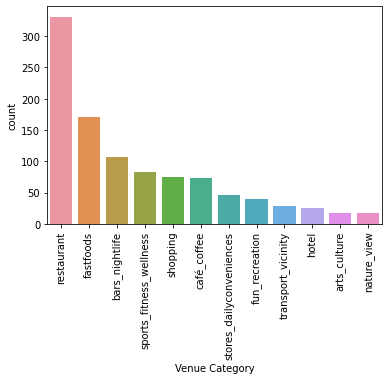

In [76]:
#mumbai_venues.groupby('Macro Category').count()['Hood']
chart = sns.countplot(x='Venue Category', data=venue_analysis, orient='h', order=venue_analysis['Venue Category'].value_counts().index) 
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

<b>Inference</b><br>
Analysing the venue data from the Fourquare API shows that Mumbai has a thriving restaurant and nightlife scene since restaurants, fastfoods and bars dominate the venues. Mumbai also has substantial number of venues for those into sports, fitness and wellness.


### Preparing final data for further modelling and analysis

In [77]:
mumbai_venues.tail()

,Hood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue SubCategory,Venue Category
1220,Worli Sea Face,19.005448,72.813757,Kaasha Spa And Nutrition,19.004006,72.817070,Spa,sports_fitness_wellness
1221,Worli Sea Face,19.005448,72.813757,Papaya,19.005762,72.817621,Sushi Restaurant,restaurant
1222,Worli Sea Face,19.005448,72.813757,Luna nudo gusta,19.005851,72.817693,Lounge,bars_nightlife
1223,Worli Sea Face,19.005448,72.813757,Paul Smith,19.005880,72.817706,Accessories Store,shopping
1224,Worli Sea Face,19.005448,72.813757,Pool Deck,19.005867,72.817742,Café,café_coffee


In [78]:
# one-hot encoding to get venue category frequencies per neighborhood

onehot = pd.get_dummies(mumbai_venues['Venue Category'])
mumbai_venues_one_hot = pd.concat([mumbai_venues['Hood'],onehot], axis=1)

In [79]:
mumbai_venues_one_hot.head()

,Hood,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
0,Agripada,0,0,0,1,0,0,0,0,0,0,0,0
1,Agripada,0,0,1,0,0,0,0,0,0,0,0,0
2,Agripada,0,0,0,0,0,0,0,0,0,1,0,0
3,Agripada,0,0,0,0,0,0,0,0,0,1,0,0
4,Agripada,0,0,0,0,0,0,0,0,0,0,0,1


In [80]:
venue_by_hood = mumbai_venues_one_hot.groupby('Hood').sum()
venue_by_hood.head()#.shape

,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
Hood,,,,,,,,,,,,
Agripada,0,0,1,1,0,0,0,0,0,2,0,1
Andheri East,0,1,0,2,0,2,0,3,3,0,0,0
Antop Hill,0,1,0,0,0,0,0,2,0,0,0,1
Azad Nagar,0,4,1,6,1,0,0,6,0,1,1,2
Bandra West,1,8,12,15,3,1,0,28,9,6,2,0


In [81]:
# coding column for total_venues - count and frequency

total_venues_per_hood = mumbai_venues.groupby('Hood').count()[['Venue']]
total_venues_per_hood.columns = ['total_venues']
total_venues_per_hood.head()


,total_venues
Hood,
Agripada,5
Andheri East,11
Antop Hill,4
Azad Nagar,22
Bandra West,85


In [82]:
df_locality_prop = df_locality[['locality','mean_property_rate']].copy()
df_locality_prop.index = df_locality_prop['locality']
df_locality_prop

df_model_combined = df_locality_prop[['mean_property_rate']].join(total_venues_per_hood, how='left')
df_model_combined = df_model_combined.join(venue_by_hood, how='left')
df_model_combined.fillna(0,inplace=True)
df_model_combined.head()

,mean_property_rate,total_venues,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
locality,,,,,,,,,,,,,,
Agripada,27731.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
Andheri East,16533.0,11.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0
Antop Hill,19146.5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
Azad Nagar,18700.0,22.0,0.0,4.0,1.0,6.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0
Bandra West,36040.0,85.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0
Bandra(East),29686.5,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
Bangur Nagar,17361.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
Barve Nagar,14620.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Bhandup East,14003.5,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [83]:
venue_columns = df_model_combined.columns[2:]
macro_columns = df_model_combined.columns[:2]

In [84]:
df_model_1 = df_model_combined[macro_columns]     # only macro features  
df_model_2 = df_model_combined[venue_columns]     # only venue features
df_model_3 = df_model_combined.drop('total_venues', axis=1)     # only property + venue features

In [85]:
df_model_3.head()

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
locality,,,,,,,,,,,,,
Agripada,27731.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
Andheri East,16533.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0
Antop Hill,19146.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
Azad Nagar,18700.0,0.0,4.0,1.0,6.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0
Bandra West,36040.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0


In [86]:
def min_max_scaler_fit(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    
    return scaler.transform(df)

In [129]:
df_model_unscaled = df_model_combined

df_model_scaled = min_max_scaler_fit(df_model_unscaled)

In [130]:
df_model = pd.DataFrame(data=df_model_scaled, columns=df_model_unscaled.columns, index=df_model_unscaled.index)
# np.round(final_data*4+1).astype(int)
df_model = df_model.reset_index()
df_model

,locality,mean_property_rate,total_venues,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
0,Agripada,0.393455,0.058824,0.0,0.000000,0.083333,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.333333,0.00,0.333333
1,Andheri East,0.154036,0.129412,0.0,0.090909,0.000000,0.111111,0.000000,0.50,0.000000,0.107143,0.333333,0.000000,0.00,0.000000
2,Antop Hill,0.209914,0.047059,0.0,0.090909,0.000000,0.000000,0.000000,0.00,0.000000,0.071429,0.000000,0.000000,0.00,0.333333
3,Azad Nagar,0.200368,0.258824,0.0,0.363636,0.083333,0.333333,0.333333,0.00,0.000000,0.214286,0.000000,0.166667,0.25,0.666667
4,Bandra West,0.571106,1.000000,0.5,0.727273,1.000000,0.833333,1.000000,0.25,0.000000,1.000000,1.000000,1.000000,0.50,0.000000
5,Bandra(East),0.435265,0.094118,0.5,0.000000,0.083333,0.055556,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.00,0.333333
6,Bangur Nagar,0.171739,0.070588,0.0,0.000000,0.250000,0.000000,0.000000,0.00,0.000000,0.000000,0.222222,0.000000,0.25,0.000000
7,Barve Nagar,0.113135,0.047059,0.0,0.000000,0.166667,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.333333
8,Bhandup East,0.099954,0.047059,0.0,0.090909,0.000000,0.055556,0.000000,0.00,0.000000,0.035714,0.000000,0.000000,0.00,0.333333
9,Bhandup West,0.091327,0.070588,0.0,0.000000,0.083333,0.000000,0.666667,0.00,0.000000,0.071429,0.000000,0.000000,0.25,0.000000


### KMeans Clustering Technique - Analysing localities based on the similarity of property rates and venues

##### Determing best number of clusters (k) using elbow method

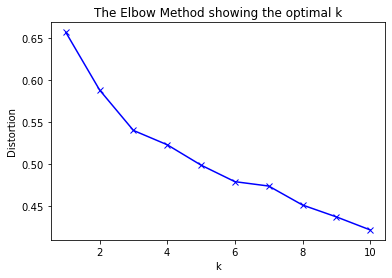

In [186]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


X = df_model.drop(['locality'], 1)


# k means determine k
distortions = []
K = range(1,11)
rstate = 11
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=rstate).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [187]:
distortions

[0.6568015442198845,
 0.5881032702723538,
 0.5400251332173691,
 0.5229873124237076,
 0.49875937230231215,
 0.4791066215619141,
 0.473899283188091,
 0.45133245426337343,
 0.4372440390656126,
 0.4217266544392378]

### Running KMeans for best k

In [188]:
# set number of clusters and random_state

# rstate = 4 from above
kclusters = 3

df_model_clustering = df_model.drop('locality', axis = 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=rstate).fit(df_model_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0], dtype=int32)

In [189]:
df_analyse = df_model_unscaled.reset_index().copy()

In [190]:
df_analyse['ClusterLabels'] = kmeans.labels_

In [191]:
df_analyse

,locality,mean_property_rate,total_venues,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,ClusterLabels
0,Agripada,27731.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1
1,Andheri East,16533.0,11.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,1
2,Antop Hill,19146.5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1
3,Azad Nagar,18700.0,22.0,0.0,4.0,1.0,6.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0,0
4,Bandra West,36040.0,85.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0,2
5,Bandra(East),29686.5,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1
6,Bangur Nagar,17361.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1
7,Barve Nagar,14620.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
8,Bhandup East,14003.5,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
9,Bhandup West,13600.0,6.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0


##### Merging df_analyse with latitude and longitude to view clusters on map and further analyse

In [192]:
df_final = df_locality[['locality','pincode','latitude','longitude']].merge(df_analyse, on='locality', how='left')
df_final.head()

,locality,pincode,latitude,longitude,mean_property_rate,total_venues,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,ClusterLabels
0,Agripada,400011,18.975302,72.824898,27731.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1
1,Andheri East,400069,19.115883,72.854202,16533.0,11.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,1
2,Antop Hill,400037,19.020761,72.865256,19146.5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1
3,Azad Nagar,400053,19.128315,72.840038,18700.0,22.0,0.0,4.0,1.0,6.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0,0
4,Bandra West,400050,19.058336,72.830267,36040.0,85.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0,2


In [193]:
# converting cluster labels to int and viewing final dataframe

df_final['ClusterLabels'] = df_final['ClusterLabels'].astype(int)
df_final

,locality,pincode,latitude,longitude,mean_property_rate,total_venues,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,ClusterLabels
0,Agripada,400011,18.975302,72.824898,27731.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1
1,Andheri East,400069,19.115883,72.854202,16533.0,11.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0,1
2,Antop Hill,400037,19.020761,72.865256,19146.5,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1
3,Azad Nagar,400053,19.128315,72.840038,18700.0,22.0,0.0,4.0,1.0,6.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0,0
4,Bandra West,400050,19.058336,72.830267,36040.0,85.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0,2
5,Bandra(East),400051,19.061657,72.849811,29686.5,8.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1
6,Bangur Nagar,400104,19.168814,72.833678,17361.0,6.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1
7,Barve Nagar,400084,19.095283,72.900178,14620.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
8,Bhandup East,400042,19.148557,72.947066,14003.5,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
9,Bhandup West,400078,19.146264,72.933946,13600.0,6.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0


In [194]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   locality                  90 non-null     object 
 1   pincode                   90 non-null     int64  
 2   latitude                  90 non-null     float64
 3   longitude                 90 non-null     float64
 4   mean_property_rate        90 non-null     float64
 5   total_venues              90 non-null     float64
 6   arts_culture              90 non-null     float64
 7   bars_nightlife            90 non-null     float64
 8   café_coffee               90 non-null     float64
 9   fastfoods                 90 non-null     float64
 10  fun_recreation            90 non-null     float64
 11  hotel                     90 non-null     float64
 12  nature_view               90 non-null     float64
 13  restaurant                90 non-null     float64
 14  shopping    

##### Viewing neighborhoods on map and clusters

In [195]:
# create map
map_clusters = folium.Map(location=[mumbai_latitude, mumbai_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['latitude'], df_final['longitude'], df_final['locality'], df_final['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Drilling into each cluster

In [196]:
def cluster_box_plots(df):
    skip = ['locality','pincode','latitude','longitude','ClusterLabels']
    
    for col in df.columns:
        plt.figure()
        
        if col not in skip:
            sns.boxplot(data=df, x='ClusterLabels', y=col)
        else:
            continue


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

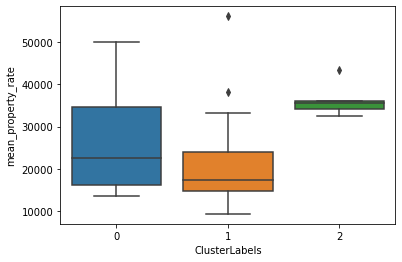

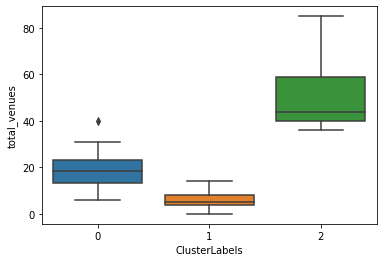

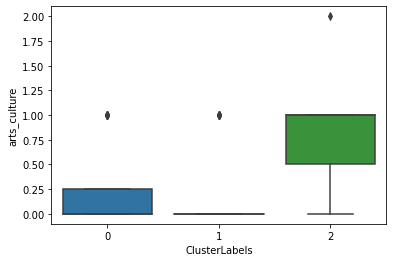

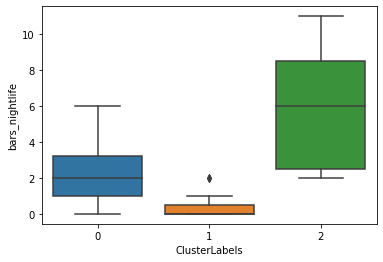

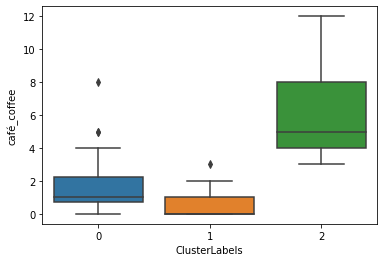

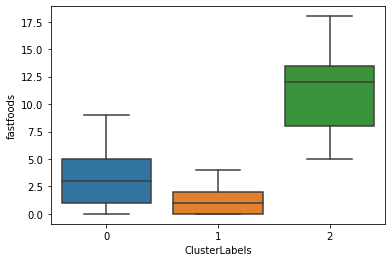

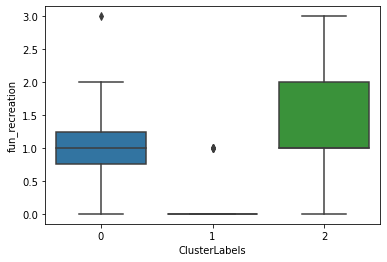

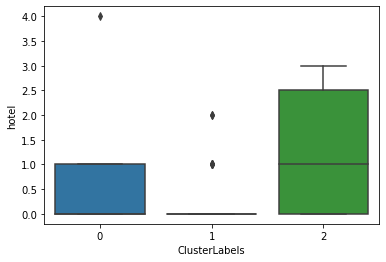

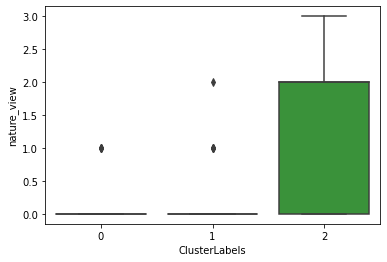

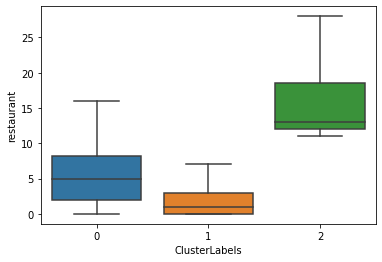

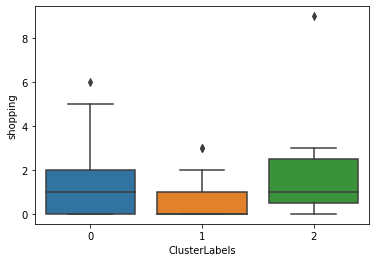

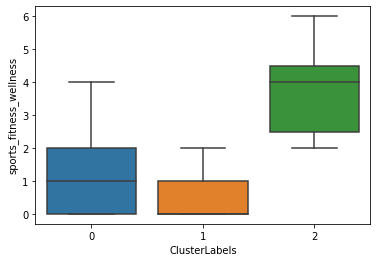

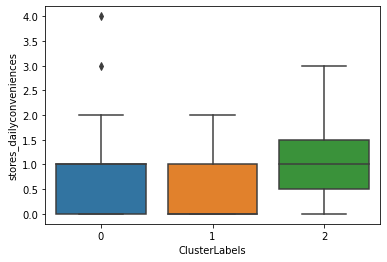

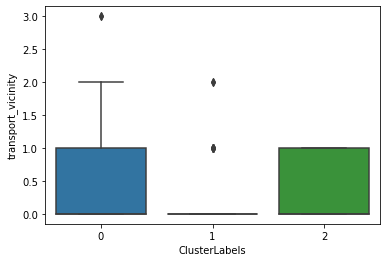

<Figure size 432x288 with 0 Axes>

In [197]:
cluster_box_plots(df_final)

In [198]:
df_final['ClusterLabels'].value_counts()

1    55
0    28
2     7
Name: ClusterLabels, dtype: int64

In [204]:
df_final[df_final['ClusterLabels']==2]

,locality,pincode,latitude,longitude,mean_property_rate,total_venues,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,ClusterLabels
4,Bandra West,400050,19.058336,72.830267,36040.0,85.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0,2
14,Charni Road,400004,18.952456,72.817440,33468.5,40.0,2.0,2.0,3.0,12.0,2.0,0.0,3.0,12.0,0.0,2.0,1.0,1.0,2
18,Churchgate,400020,18.930657,72.826255,43435.0,44.0,0.0,3.0,4.0,12.0,1.0,3.0,2.0,12.0,1.0,4.0,1.0,1.0,2
31,Hiranandani Gardens - Powai,400076,19.117628,72.909294,35000.0,71.0,1.0,6.0,9.0,18.0,1.0,2.0,0.0,22.0,3.0,5.0,3.0,1.0,2
37,Juhu,400049,19.107021,72.827528,35636.5,47.0,0.0,11.0,7.0,5.0,1.0,3.0,2.0,13.0,0.0,4.0,1.0,0.0,2
43,Khar,400052,19.071770,72.835036,35976.5,36.0,1.0,9.0,4.0,6.0,0.0,0.0,0.0,11.0,2.0,3.0,0.0,0.0,2
77,Shivaji Park,400028,19.027236,72.838348,32491.5,40.0,1.0,2.0,5.0,10.0,2.0,0.0,2.0,15.0,1.0,2.0,0.0,0.0,2


<h3>Inferences</h3><br>
Clustering the neighborhoods on the available venues gives us four clusters:-
    <li>Cluster 0 - Localities in this cluster have moderate number of facilities. Property rates vary greatly for localities in this cluster from average to high prices. There are some facilities for restaurants, shopping, fun_recreation and public transport. Number of facilities for the remaining are average.
    <li>Cluster 1 - Localities in this cluster havelow number of facilities. There is no specific facility that significantly stands out. These localities are relatively cheap to live in barring a few outlier expensive places.
    <li>Cluster 2 - This has the most happening localities. It has the localities with most number of facilities/amenities (venues) and high property prices. Places in this cluster are big on fast_foods, cafes, restaurants, bars_nightlife, sports_fitness_wellness arts_culture, and have an option for nature spots. 

## Recommendation

Using df_model_3 to building item matrix for recommendation

In [205]:
df_model_3

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
locality,,,,,,,,,,,,,
Agripada,27731.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0
Andheri East,16533.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0
Antop Hill,19146.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
Azad Nagar,18700.0,0.0,4.0,1.0,6.0,1.0,0.0,0.0,6.0,0.0,1.0,1.0,2.0
Bandra West,36040.0,1.0,8.0,12.0,15.0,3.0,1.0,0.0,28.0,9.0,6.0,2.0,0.0
Bandra(East),29686.5,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0
Bangur Nagar,17361.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
Barve Nagar,14620.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Bhandup East,14003.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [206]:
# scaling df_model_3 for recommendations

scaler = MinMaxScaler()
scaler.fit(df_model_3)
final_data = scaler.transform(df_model_3)


In [207]:
df_item_matrix = pd.DataFrame(data=final_data, columns=df_model_3.columns, index=df_model_3.index)

In [208]:
df_item_matrix

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
locality,,,,,,,,,,,,,
Agripada,0.393455,0.0,0.000000,0.083333,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.333333,0.00,0.333333
Andheri East,0.154036,0.0,0.090909,0.000000,0.111111,0.000000,0.50,0.000000,0.107143,0.333333,0.000000,0.00,0.000000
Antop Hill,0.209914,0.0,0.090909,0.000000,0.000000,0.000000,0.00,0.000000,0.071429,0.000000,0.000000,0.00,0.333333
Azad Nagar,0.200368,0.0,0.363636,0.083333,0.333333,0.333333,0.00,0.000000,0.214286,0.000000,0.166667,0.25,0.666667
Bandra West,0.571106,0.5,0.727273,1.000000,0.833333,1.000000,0.25,0.000000,1.000000,1.000000,1.000000,0.50,0.000000
Bandra(East),0.435265,0.5,0.000000,0.083333,0.055556,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.00,0.333333
Bangur Nagar,0.171739,0.0,0.000000,0.250000,0.000000,0.000000,0.00,0.000000,0.000000,0.222222,0.000000,0.25,0.000000
Barve Nagar,0.113135,0.0,0.000000,0.166667,0.055556,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.333333
Bhandup East,0.099954,0.0,0.090909,0.000000,0.055556,0.000000,0.00,0.000000,0.035714,0.000000,0.000000,0.00,0.333333


In [209]:

# Personas: 
#     Student
#     Working
#     Active/Outdoor
#     Tourist
#     Family

#     Old Social
#     Old Peacful
    
    
user_student = {'mean_property_rate':1,
                'arts_culture':4, 
                  'bars_nightlife':3, 
                  'café_coffee':2,
                  'fastfoods':5, 
                  'fun_recreation':5,
                  'hotel':1, 
                  'nature_view':1,
                  'restaurant':2, 
                  'shopping':1, 
                  'sports_fitness_wellness':3, 
                  'stores_dailyconveniences':3,
                  'transport_vicinity':5
          }
user_bachelorsocialworking = {
          'mean_property_rate':5,
          'arts_culture':3, 
          'bars_nightlife':4, 
          'café_coffee':4,
          'fastfoods':2, 
          'fun_recreation':2,
          'hotel':3, 
          'nature_view':3,
          'restaurant':5, 
          'shopping':4, 
          'sports_fitness_wellness':3, 
          'stores_dailyconveniences':4,
          'transport_vicinity':1}
user_familychildren = {
          'mean_property_rate':4,
          'arts_culture':1, 
          'bars_nightlife':1, 
          'café_coffee':1,
          'fastfoods':3, 
          'fun_recreation':3,
          'hotel':2, 
          'nature_view':2,
          'restaurant':4, 
          'shopping':3, 
          'sports_fitness_wellness':2, 
          'stores_dailyconveniences':5,
          'transport_vicinity':3}
user_peacefulactiveworking = {
        'mean_property_rate':3,
          'arts_culture':4, 
          'bars_nightlife':2, 
          'café_coffee':5,
          'fastfoods':1, 
          'fun_recreation':3,
          'hotel':1, 
          'nature_view':5,
          'restaurant':3, 
          'shopping':1, 
          'sports_fitness_wellness':5, 
          'stores_dailyconveniences':3,
          'transport_vicinity':2
            }
user_socialtourist = {
        'mean_property_rate':2,
        'arts_culture':5, 
          'bars_nightlife':5, 
          'café_coffee':4, 
          'fastfoods':4, 
          'fun_recreation':4,
          'hotel':5, 
          'nature_view':4,
          'restaurant':4, 
          'shopping':4, 
          'sports_fitness_wellness':1, 
          'stores_dailyconveniences':2,
          'transport_vicinity':4
          }



In [261]:
# from scipy import spatial
# 1 - spatial.distance.cosine(np.array(df_item_matrix), np.array(df_user))

In [210]:
df_user = pd.DataFrame(columns=df_item_matrix.columns, dtype='float')

In [211]:
df_user = df_user.append(user_student,ignore_index=True)
df_user = df_user.append(user_bachelorsocialworking,ignore_index=True)
df_user = df_user.append(user_familychildren,ignore_index=True)
df_user = df_user.append(user_peacefulactiveworking,ignore_index=True)
df_user = df_user.append(user_socialtourist,ignore_index=True)
df_user.index = ['user_student','user_bachelorsocialworking','user_familychildren','user_peacefulactiveworking','user_socialtourist']

# Linearly scaling the user input data to range from 0 to 1 where user input 1 implies 0 and user input 5 implies 1 
df_user = df_user/4 -0.25

In [212]:
df_user

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
user_student,0.00,0.75,0.50,0.25,1.00,1.00,0.00,0.00,0.25,0.00,0.50,0.50,1.00
user_bachelorsocialworking,1.00,0.50,0.75,0.75,0.25,0.25,0.50,0.50,1.00,0.75,0.50,0.75,0.00
user_familychildren,0.75,0.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.50,0.25,1.00,0.50
user_peacefulactiveworking,0.50,0.75,0.25,1.00,0.00,0.50,0.00,1.00,0.50,0.00,1.00,0.50,0.25
user_socialtourist,0.25,1.00,1.00,0.75,0.75,0.75,1.00,0.75,0.75,0.75,0.00,0.25,0.75


In [213]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, user_student to user_socialtourist
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mean_property_rate        5 non-null      float64
 1   arts_culture              5 non-null      float64
 2   bars_nightlife            5 non-null      float64
 3   café_coffee               5 non-null      float64
 4   fastfoods                 5 non-null      float64
 5   fun_recreation            5 non-null      float64
 6   hotel                     5 non-null      float64
 7   nature_view               5 non-null      float64
 8   restaurant                5 non-null      float64
 9   shopping                  5 non-null      float64
 10  sports_fitness_wellness   5 non-null      float64
 11  stores_dailyconveniences  5 non-null      float64
 12  transport_vicinity        5 non-null      float64
dtypes: float64(13)
memory usage: 560.0+ bytes


In [214]:
df_user.index

Index(['user_student', 'user_bachelorsocialworking', 'user_familychildren',
       'user_peacefulactiveworking', 'user_socialtourist'],
      dtype='object')

In [238]:
# reco_value.shape
def cos_sim(df_item_matrix, df_user):
    cos_sim = cosine_similarity(X=np.array(df_item_matrix), Y=np.array(df_user))
    reco_value = (cos_sim)
    
    return reco_value.reshape([df_item_matrix.shape[0]])

def correlation(df_item_matrix, df_user):
    hood_correlation = pd.Series(dtype=float)
    
    for hood in df_item_matrix.index:
        corr_val = df_item_matrix[df_item_matrix.index==hood].reset_index(drop=True).corrwith(other=df_user.reset_index(drop=True), axis=1)
        hood_correlation = hood_correlation.append(corr_val, ignore_index=True)
        
    return hood_correlation.dropna().values


In [239]:
def user_reco(df_item, df_user):
    df_reco_final = df_item.copy()
    for user in df_user.index:
        user_persona = df_user[df_user.index==user]
        df_reco_final[user+'_cosine'] = cos_sim(df_item, user_persona)
        df_reco_final[user+'_correlation'] = correlation(df_item, user_persona)
        
    return df_reco_final

    #pd.DataFrame(data=user_1)
    #df_user = df_user/5

In [240]:
df_reco_check = user_reco(df_item_matrix, df_user)

In [241]:
df_reco_check.head()

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Agripada,0.393455,0.0,0.000000,0.083333,0.055556,0.000000,0.00,0.0,0.000000,0.000000,0.333333,0.00,0.333333,0.439802,0.063643,0.441293,-0.102594,0.505928,0.154410,0.517253,0.176346,0.273703,-0.622474
Andheri East,0.154036,0.0,0.090909,0.000000,0.111111,0.000000,0.50,0.0,0.107143,0.333333,0.000000,0.00,0.000000,0.134798,-0.528526,0.572574,0.198780,0.462143,0.033311,0.109670,-0.675617,0.607883,0.293430
Antop Hill,0.209914,0.0,0.090909,0.000000,0.000000,0.000000,0.00,0.0,0.071429,0.000000,0.000000,0.00,0.333333,0.458648,0.170241,0.367227,-0.155747,0.505458,0.235302,0.277588,-0.197569,0.409671,-0.071515
Azad Nagar,0.200368,0.0,0.363636,0.083333,0.333333,0.333333,0.00,0.0,0.214286,0.000000,0.166667,0.25,0.666667,0.861186,0.690425,0.516778,-0.461135,0.703716,0.290594,0.469112,-0.283806,0.645254,-0.079689
Bandra West,0.571106,0.5,0.727273,1.000000,0.833333,1.000000,0.25,0.0,1.000000,1.000000,1.000000,0.50,0.000000,0.680332,0.063754,0.861241,0.365707,0.702038,0.015819,0.708774,0.036986,0.757709,-0.191801


### Observing recommendation outputs from cosine similarity and correlation techniques

In [242]:
df_user[df_user.index=='user_student']

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
user_student,0.0,0.75,0.5,0.25,1.0,1.0,0.0,0.0,0.25,0.0,0.5,0.5,1.0


In [243]:
df_reco_check.sort_values(by='user_student_cosine', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Azad Nagar,0.200368,0.0,0.363636,0.083333,0.333333,0.333333,0.0,0.0,0.214286,0.000000,0.166667,0.25,0.666667,0.861186,0.690425,0.516778,-0.461135,0.703716,0.290594,0.469112,-0.283806,0.645254,-0.079689
Kalbadevi,0.318955,0.5,0.090909,0.250000,0.277778,0.666667,0.0,0.0,0.285714,0.111111,0.000000,0.25,0.333333,0.844037,0.621865,0.633730,-0.228726,0.697777,0.201346,0.625926,0.009806,0.744052,0.133974
Mulund West,0.130400,0.5,0.090909,0.083333,0.388889,0.666667,0.0,0.0,0.107143,0.111111,0.333333,0.00,0.000000,0.797307,0.602528,0.485213,-0.336848,0.461233,-0.157319,0.581254,0.109686,0.613703,0.022163
Girgaon,0.552024,0.0,0.181818,0.000000,0.444444,0.666667,0.0,0.0,0.107143,0.000000,0.500000,0.25,0.333333,0.773100,0.514086,0.547853,-0.279452,0.735190,0.398620,0.550114,-0.039115,0.489078,-0.546155
Matunga,0.479779,0.0,0.181818,0.166667,0.500000,0.333333,0.0,0.0,0.250000,0.444444,0.166667,0.50,1.000000,0.757612,0.435314,0.580359,-0.331211,0.827179,0.568344,0.440188,-0.415228,0.622363,-0.246917


In [244]:
df_reco_check.sort_values(by='user_student_correlation', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Azad Nagar,0.200368,0.0,0.363636,0.083333,0.333333,0.333333,0.0,0.0,0.214286,0.000000,0.166667,0.25,0.666667,0.861186,0.690425,0.516778,-0.461135,0.703716,0.290594,0.469112,-0.283806,0.645254,-0.079689
Kalbadevi,0.318955,0.5,0.090909,0.250000,0.277778,0.666667,0.0,0.0,0.285714,0.111111,0.000000,0.25,0.333333,0.844037,0.621865,0.633730,-0.228726,0.697777,0.201346,0.625926,0.009806,0.744052,0.133974
Mulund West,0.130400,0.5,0.090909,0.083333,0.388889,0.666667,0.0,0.0,0.107143,0.111111,0.333333,0.00,0.000000,0.797307,0.602528,0.485213,-0.336848,0.461233,-0.157319,0.581254,0.109686,0.613703,0.022163
Girgaon,0.552024,0.0,0.181818,0.000000,0.444444,0.666667,0.0,0.0,0.107143,0.000000,0.500000,0.25,0.333333,0.773100,0.514086,0.547853,-0.279452,0.735190,0.398620,0.550114,-0.039115,0.489078,-0.546155
Jogeshwari West,0.144030,0.5,0.363636,0.083333,0.055556,1.000000,0.0,0.0,0.250000,0.000000,0.000000,0.00,0.000000,0.662691,0.454290,0.441431,-0.134006,0.372400,-0.130195,0.473878,0.071325,0.601375,0.298083


In [245]:
df_user[df_user.index=='user_bachelorsocialworking']

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
user_bachelorsocialworking,1.0,0.5,0.75,0.75,0.25,0.25,0.5,0.5,1.0,0.75,0.5,0.75,0.0


In [246]:
df_reco_check.sort_values(by='user_bachelorsocialworking_cosine', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Bandra West,0.571106,0.5,0.727273,1.000000,0.833333,1.000000,0.25,0.000000,1.000000,1.000000,1.000000,0.50,0.000000,0.680332,0.063754,0.861241,0.365707,0.702038,0.015819,0.708774,0.036986,0.757709,-0.191801
Malad West,0.118587,0.0,0.454545,0.166667,0.055556,0.000000,0.25,0.000000,0.321429,0.333333,0.166667,0.25,0.000000,0.370056,-0.448404,0.858518,0.642642,0.613718,0.041579,0.465036,-0.332363,0.695758,0.052331
Hiranandani Gardens - Powai,0.548871,0.5,0.545455,0.750000,1.000000,0.333333,0.50,0.000000,0.785714,0.333333,0.833333,0.75,0.333333,0.750826,0.233757,0.853975,0.217349,0.767996,0.168423,0.708970,-0.067067,0.771137,-0.330508
Juhu,0.562479,0.0,1.000000,0.583333,0.277778,0.333333,0.75,0.666667,0.464286,0.000000,0.666667,0.25,0.000000,0.459834,-0.414670,0.820456,0.349086,0.536614,-0.331514,0.725999,0.211913,0.735850,-0.034935
Haji Ali,0.571566,0.0,0.363636,0.000000,0.277778,0.000000,0.00,0.333333,0.178571,0.222222,0.166667,0.25,0.000000,0.373841,-0.387895,0.808697,0.521189,0.721142,0.342158,0.556894,-0.056184,0.552245,-0.389428


In [247]:
df_reco_check.sort_values(by='user_bachelorsocialworking_correlation', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Parel,0.323049,0.0,0.000000,0.166667,0.000000,0.0,0.00,0.0,0.071429,0.111111,0.000000,0.25,0.0,0.190207,-0.423844,0.740206,0.658679,0.717529,0.547545,0.490341,0.091618,0.331054,-0.519750
Malad West,0.118587,0.0,0.454545,0.166667,0.055556,0.0,0.25,0.0,0.321429,0.333333,0.166667,0.25,0.0,0.370056,-0.448404,0.858518,0.642642,0.613718,0.041579,0.465036,-0.332363,0.695758,0.052331
Lal Baug,0.389831,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.142857,0.111111,0.000000,0.00,0.0,0.039447,-0.462850,0.618226,0.611140,0.581758,0.456974,0.286229,-0.085135,0.252089,-0.343369
Vikhroli,0.097698,0.0,0.000000,0.166667,0.000000,0.0,0.00,0.0,0.142857,0.000000,0.000000,0.00,0.0,0.152884,-0.351985,0.656236,0.601627,0.412567,0.068928,0.551598,0.331390,0.401808,-0.076295
Malad East,0.104048,0.0,0.090909,0.000000,0.000000,0.0,0.00,0.0,0.071429,0.111111,0.000000,0.25,0.0,0.284058,-0.247277,0.705161,0.568023,0.763246,0.641801,0.345586,-0.194681,0.378228,-0.373355


In [248]:
df_user[df_user.index=='user_familychildren']

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
user_familychildren,0.75,0.0,0.0,0.0,0.5,0.5,0.25,0.25,0.75,0.5,0.25,1.0,0.5


In [249]:
df_reco_check.sort_values(by='user_familychildren_cosine', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Liberty Garden,0.146756,0.0,0.000000,0.000000,0.055556,0.000000,0.00,0.0,0.178571,0.111111,0.166667,0.25,0.000000,0.367154,-0.219401,0.749724,0.534331,0.852564,0.746431,0.526039,0.043563,0.337803,-0.756837
Mumbai Central,0.578825,0.0,0.000000,0.000000,0.222222,0.333333,0.25,0.0,0.035714,0.000000,0.166667,0.50,0.333333,0.600196,0.165537,0.592128,-0.082312,0.851747,0.690853,0.461967,-0.207157,0.468802,-0.544127
Santacruz(West),0.529307,0.0,0.000000,0.083333,0.277778,0.333333,0.00,0.0,0.178571,0.666667,0.166667,0.50,0.000000,0.432370,-0.179789,0.731897,0.366305,0.848061,0.687129,0.425133,-0.280881,0.479203,-0.490104
Matunga,0.479779,0.0,0.181818,0.166667,0.500000,0.333333,0.00,0.0,0.250000,0.444444,0.166667,0.50,1.000000,0.757612,0.435314,0.580359,-0.331211,0.827179,0.568344,0.440188,-0.415228,0.622363,-0.246917
Sion East,0.312135,0.0,0.000000,0.000000,0.111111,0.333333,0.00,0.0,0.142857,0.000000,0.166667,0.25,0.000000,0.567599,0.173543,0.626924,0.170305,0.815957,0.665518,0.550120,0.091896,0.379679,-0.631972


In [250]:
df_reco_check.sort_values(by='user_familychildren_correlation', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Liberty Garden,0.146756,0.0,0.0,0.000000,0.055556,0.000000,0.00,0.0,0.178571,0.111111,0.166667,0.25,0.000000,0.367154,-0.219401,0.749724,0.534331,0.852564,0.746431,0.526039,0.043563,0.337803,-0.756837
Mumbai Central,0.578825,0.0,0.0,0.000000,0.222222,0.333333,0.25,0.0,0.035714,0.000000,0.166667,0.50,0.333333,0.600196,0.165537,0.592128,-0.082312,0.851747,0.690853,0.461967,-0.207157,0.468802,-0.544127
Santacruz(West),0.529307,0.0,0.0,0.083333,0.277778,0.333333,0.00,0.0,0.178571,0.666667,0.166667,0.50,0.000000,0.432370,-0.179789,0.731897,0.366305,0.848061,0.687129,0.425133,-0.280881,0.479203,-0.490104
Shivaji Nagar,0.227628,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.222222,0.000000,0.50,0.000000,0.200261,-0.232856,0.559923,0.407217,0.724870,0.687040,0.283552,-0.134830,0.221330,-0.505693
Sion East,0.312135,0.0,0.0,0.000000,0.111111,0.333333,0.00,0.0,0.142857,0.000000,0.166667,0.25,0.000000,0.567599,0.173543,0.626924,0.170305,0.815957,0.665518,0.550120,0.091896,0.379679,-0.631972


In [251]:
df_user[df_user.index=='user_peacefulactiveworking']

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
user_peacefulactiveworking,0.5,0.75,0.25,1.0,0.0,0.5,0.0,1.0,0.5,0.0,1.0,0.5,0.25


In [252]:
df_reco_check.sort_values(by='user_peacefulactiveworking_cosine', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Shivaji Park,0.495237,0.5,0.181818,0.416667,0.555556,0.666667,0.00,0.666667,0.535714,0.111111,0.333333,0.00,0.000000,0.653703,0.098013,0.743190,0.048763,0.610915,-0.116704,0.816257,0.472313,0.747684,0.016881
Charni Road,0.516126,1.0,0.181818,0.250000,0.666667,0.666667,0.00,1.000000,0.428571,0.000000,0.333333,0.25,0.333333,0.730799,0.307929,0.661147,-0.249990,0.605471,-0.118852,0.812572,0.467886,0.757497,0.077569
Cumballa Hill,0.610179,0.0,0.090909,0.416667,0.444444,0.333333,0.00,0.333333,0.071429,0.111111,0.666667,0.25,0.000000,0.544334,-0.061856,0.714465,0.130643,0.653392,0.127152,0.781782,0.452433,0.488377,-0.748044
Juhu,0.562479,0.0,1.000000,0.583333,0.277778,0.333333,0.75,0.666667,0.464286,0.000000,0.666667,0.25,0.000000,0.459834,-0.414670,0.820456,0.349086,0.536614,-0.331514,0.725999,0.211913,0.735850,-0.034935
Chembur,0.158569,0.5,0.272727,0.166667,0.055556,0.000000,0.00,0.000000,0.464286,0.000000,0.500000,0.00,0.333333,0.634696,0.231180,0.646488,0.072439,0.441772,-0.264654,0.710368,0.357431,0.606669,-0.095222


In [253]:
df_reco_check.sort_values(by='user_peacefulactiveworking_correlation', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Shivaji Park,0.495237,0.5,0.181818,0.416667,0.555556,0.666667,0.0,0.666667,0.535714,0.111111,0.333333,0.00,0.000000,0.653703,0.098013,0.743190,0.048763,0.610915,-0.116704,0.816257,0.472313,0.747684,0.016881
Charni Road,0.516126,1.0,0.181818,0.250000,0.666667,0.666667,0.0,1.000000,0.428571,0.000000,0.333333,0.25,0.333333,0.730799,0.307929,0.661147,-0.249990,0.605471,-0.118852,0.812572,0.467886,0.757497,0.077569
Cumballa Hill,0.610179,0.0,0.090909,0.416667,0.444444,0.333333,0.0,0.333333,0.071429,0.111111,0.666667,0.25,0.000000,0.544334,-0.061856,0.714465,0.130643,0.653392,0.127152,0.781782,0.452433,0.488377,-0.748044
Pant Nagar,0.171290,0.0,0.090909,0.083333,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.00,0.000000,0.280293,-0.141063,0.512342,0.216891,0.294959,-0.164709,0.614656,0.441714,0.187155,-0.694231
Mhada Colony,0.114952,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.00,0.000000,0.224388,-0.069616,0.344503,0.068068,0.264201,-0.031894,0.511935,0.409545,0.030669,-0.763907


In [254]:
df_user[df_user.index=='user_socialtourist']

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity
user_socialtourist,0.25,1.0,1.0,0.75,0.75,0.75,1.0,0.75,0.75,0.75,0.0,0.25,0.75


In [255]:
df_reco_check.sort_values(by='user_socialtourist_cosine', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Hiranandani Gardens - Powai,0.548871,0.5,0.545455,0.750000,1.000000,0.333333,0.50,0.000000,0.785714,0.333333,0.833333,0.75,0.333333,0.750826,0.233757,0.853975,0.217349,0.767996,0.168423,0.708970,-0.067067,0.771137,-0.330508
Bandra West,0.571106,0.5,0.727273,1.000000,0.833333,1.000000,0.25,0.000000,1.000000,1.000000,1.000000,0.50,0.000000,0.680332,0.063754,0.861241,0.365707,0.702038,0.015819,0.708774,0.036986,0.757709,-0.191801
Charni Road,0.516126,1.0,0.181818,0.250000,0.666667,0.666667,0.00,1.000000,0.428571,0.000000,0.333333,0.25,0.333333,0.730799,0.307929,0.661147,-0.249990,0.605471,-0.118852,0.812572,0.467886,0.757497,0.077569
Shivaji Park,0.495237,0.5,0.181818,0.416667,0.555556,0.666667,0.00,0.666667,0.535714,0.111111,0.333333,0.00,0.000000,0.653703,0.098013,0.743190,0.048763,0.610915,-0.116704,0.816257,0.472313,0.747684,0.016881
Kalbadevi,0.318955,0.5,0.090909,0.250000,0.277778,0.666667,0.00,0.000000,0.285714,0.111111,0.000000,0.25,0.333333,0.844037,0.621865,0.633730,-0.228726,0.697777,0.201346,0.625926,0.009806,0.744052,0.133974


In [256]:
df_reco_check.sort_values(by='user_socialtourist_correlation', ascending=False).head(5)

,mean_property_rate,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,user_student_cosine,user_student_correlation,user_bachelorsocialworking_cosine,user_bachelorsocialworking_correlation,user_familychildren_cosine,user_familychildren_correlation,user_peacefulactiveworking_cosine,user_peacefulactiveworking_correlation,user_socialtourist_cosine,user_socialtourist_correlation
locality,,,,,,,,,,,,,,,,,,,,,,,
Jogeshwari West,0.144030,0.5,0.363636,0.083333,0.055556,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.0,0.000000,0.662691,0.454290,0.441431,-0.134006,0.372400,-0.130195,0.473878,0.071325,0.601375,0.298083
Sakinaka,0.107683,0.0,0.090909,0.083333,0.000000,0.0,0.5,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.059811,-0.423755,0.400377,0.075915,0.214883,-0.210189,0.140377,-0.347415,0.486579,0.296690
Andheri East,0.154036,0.0,0.090909,0.000000,0.111111,0.0,0.5,0.0,0.107143,0.333333,0.000000,0.0,0.000000,0.134798,-0.528526,0.572574,0.198780,0.462143,0.033311,0.109670,-0.675617,0.607883,0.293430
Tagore Nagar,0.090408,0.5,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.071429,0.000000,0.000000,0.0,0.000000,0.363463,0.151825,0.346202,0.061174,0.129973,-0.278870,0.410403,0.221590,0.422541,0.251864
Marol,0.148124,0.0,0.363636,0.416667,0.111111,0.0,1.0,0.0,0.357143,0.000000,0.333333,0.0,0.333333,0.360201,-0.272172,0.592248,0.017496,0.394978,-0.281675,0.418147,-0.231833,0.669916,0.236936


From observing recommendations suggested by correlation and cosine similarity, cosine similarity works better at providing more accurate recommendations. Hence we will consider recommendations based on <b>cosine similarity<b>.

### Recommendation - New User Testing

You are a person that wants to move to or visit a new city (<b>Mumbai</b>, in this case), have certain preferences but are unsure of which locality to stay in. You come across a recommendation engine that asks you to enter value ratings that represent your preferences of various types of facilities/amenities in the locality you want to stay in on the basis of:-
<li>    1 - Strongly Don't Want
<li>    2 - Don't Want
<li>    3 - Neutral
<li>    4 - Want
<li>    5 - Strongly Want
<br><br>    
For example, if you are a foodie and really want several options of restaurants but don't drink and party and prefer localities that don't have such venues, then you can enter the following ratings:-
    <li>restaurant - 5
    <li>bars_nightlife - 1
<br><br>          
There are a total of 13 such features that you must give ratings on and this algorithm will recommend the most feasible locality on the basis of your entered preference. You must finally enter the number 'n' for top 'n' recommendations of localities you wish to see on the map of Mumbai.

In [257]:
# Taking user's inputs      
    
new_user = {
          'mean_property_rate':4,
          'arts_culture':3, 
          'bars_nightlife':3, 
          'café_coffee':5,
          'fastfoods':3, 
          'fun_recreation':2,
          'hotel':1, 
          'nature_view':5,
          'restaurant':4,
          'shopping':2, 
          'sports_fitness_wellness':5, 
          'stores_dailyconveniences':4,
          'transport_vicinity':1
        }

no_of_recommendations = 6

In [258]:
def new_user_recommendation(new_user, top_n_recommendations):
    df_new_user = pd.DataFrame(columns=df_item_matrix.columns, dtype='float')

    df_new_user = df_new_user.append(new_user,ignore_index=True)
    df_new_user.index = ['new_user']

    df_new_user = df_new_user/4 -0.25
    
    df_reco = user_reco(df_item_matrix, df_new_user)
    hood_recommendation = df_reco.sort_values(by='new_user_cosine', ascending=False).head(top_n_recommendations).index

    df_reco = df_reco.reset_index()
    df_reco_mapview = df_housing_map.merge(df_reco, how='left',on='locality')
    
    df_reco_mapview['marker_color'] = df_reco_mapview['locality'].apply(lambda x: 'green' if any(x in hood for hood in(hood_recommendation)) else 'yellow')
    
    return df_reco_mapview.sort_values(by='new_user_cosine', ascending=False)
    

In [259]:
df_recommendation = new_user_recommendation(new_user,no_of_recommendations)
df_recommendation.head(10)

,locality,pincode,latitude,longitude,mean_property_rate_x,marker_color,mean_property_rate_y,arts_culture,bars_nightlife,café_coffee,fastfoods,fun_recreation,hotel,nature_view,restaurant,shopping,sports_fitness_wellness,stores_dailyconveniences,transport_vicinity,new_user_cosine,new_user_correlation
20,Cumballa Hill,400026,18.969307,72.806538,37867.5,green,0.610179,0.0,0.090909,0.416667,0.444444,0.333333,0.00,0.333333,0.071429,0.111111,0.666667,0.25,0.000000,0.863941,0.643964
77,Shivaji Park,400028,19.027236,72.838348,32491.5,green,0.495237,0.5,0.181818,0.416667,0.555556,0.666667,0.00,0.666667,0.535714,0.111111,0.333333,0.00,0.000000,0.837770,0.472965
31,Hiranandani Gardens - Powai,400076,19.117628,72.909294,35000.0,green,0.548871,0.5,0.545455,0.750000,1.000000,0.333333,0.50,0.000000,0.785714,0.333333,0.833333,0.75,0.333333,0.833212,0.273102
4,Bandra West,400050,19.058336,72.830267,36040.0,green,0.571106,0.5,0.727273,1.000000,0.833333,1.000000,0.25,0.000000,1.000000,1.000000,1.000000,0.50,0.000000,0.808244,0.254041
37,Juhu,400049,19.107021,72.827528,35636.5,green,0.562479,0.0,1.000000,0.583333,0.277778,0.333333,0.75,0.666667,0.464286,0.000000,0.666667,0.25,0.000000,0.806566,0.369210
18,Churchgate,400020,18.930657,72.826255,43435.0,green,0.729215,0.0,0.272727,0.333333,0.666667,0.333333,0.75,0.666667,0.428571,0.111111,0.666667,0.25,0.333333,0.796283,0.201849
14,Charni Road,400004,18.952456,72.817440,33468.5,yellow,0.516126,1.0,0.181818,0.250000,0.666667,0.666667,0.00,1.000000,0.428571,0.000000,0.333333,0.25,0.333333,0.784945,0.309591
30,Haji Ali,400034,18.977639,72.809035,36061.5,yellow,0.571566,0.0,0.363636,0.000000,0.277778,0.000000,0.00,0.333333,0.178571,0.222222,0.166667,0.25,0.000000,0.762097,0.400821
32,Irla,400056,19.111492,72.831397,24013.0,yellow,0.313963,0.0,0.181818,0.166667,0.111111,0.000000,0.00,0.000000,0.107143,0.111111,0.333333,0.00,0.000000,0.758022,0.491666
43,Khar,400052,19.071770,72.835036,35976.5,yellow,0.569749,0.5,0.818182,0.333333,0.333333,0.000000,0.00,0.000000,0.392857,0.222222,0.500000,0.00,0.000000,0.745592,0.336559


In [260]:
# create map of Mumbai using latitude and longitude values
map_mumbai = folium.Map(location=[mumbai_latitude, mumbai_longitude], zoom_start=10)

# add markers to map
for lat, lng, locality, col in zip(df_recommendation['latitude'], df_recommendation['longitude'], df_recommendation['locality'], df_recommendation['marker_color']):
    label = '{}'.format(locality)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=col,
        fill=True,
        fill_color='#999999',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mumbai)  
    
map_mumbai

Using this concept, any person moving to a new city can easily get recommendations on which locality to stay in based on their preferences of various facility/amenity/venue types they desire

# Done